In [1]:
import pandas as pd
import numpy as np
import pathlib
import os
import shutil

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_pinball_loss,
)

from utils_experiment import (
    load_data,
    get_model_list,
    plot_forecasts_analysis,
    rmse,
    pinball_loss,
    average_pinball_loss,
    plot_quantile_forecast
)

ModuleNotFoundError: No module named 'matplotlib.pyplot'

# General data loading for all experiments 

In [82]:
#Identify experiments that are not in the ignore list 
exp_test_description = "LLMP_Experiments"
directory = f"/h/kupfersk/cfpr_2025/generate_forecasts/output/"

ignore_list = [".csv",
               "ipynb",
#                 "llama",
#                 "gemini",
#                 "claude",
#                 "gpt",
               "Mixtral",
               '5th',
               "restaurants",
               "DeepARModel_exp",
               "ChronosModel_exp",
               "PatchTSTModel_exp",
               "DLinearModel_exp",
               "exp7",
               "exp8",
               "corr",
               "economic",
               "human",
#                "GPT_P",
#                "exp2_R"
#                "llm",
#                "exp1",
#                "report", 
#                "covariates",
               
]

experiments_include = []

for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
    if all(keyword not in experiment_name for keyword in ignore_list):
        experiments_include.append(experiment_name)

experiments_include

['gemini-1.5-pro_report_True',
 'gpt-4o_report_True',
 'llama-3.1-70B_future_forecasts_75_no_headers',
 'gemini-1.5-pro_report_False',
 'llama-3.1-70B_prices_only_300_no_headers',
 'llama-3.1-70B_exo_shifted_75_no_headers',
 'claude-3-5-sonnet-20240620_report_True',
 'claude-3-5-sonnet-20240620_report_False',
 'gpt-4o_report_False']

In [83]:

report_sim_dates = open("../generate_forecasts/experiment_cutoff_dates.txt", 'r').read().split()
# report_sim_dates = report_sim_dates[:1]



llmp_target_categories = [
    'Bakery and cereal products (excluding baby food)',
     'Meat',
     'Vegetables and vegetable preparations'
]
target_categories = llmp_target_categories



target_categories = [f"food_cpi: {col}" for col in target_categories]

start_years = [1986]
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))


file_path = "../data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

Target Categories:
food_cpi: Bakery and cereal products (excluding baby food)
food_cpi: Meat
food_cpi: Vegetables and vegetable preparations
Report Simulation Dates:
2018-07-01
2019-07-01
2020-07-01
2021-07-01
2022-07-01
2023-07-01


### Ensure all necessary data is stored in Experimental_Analysis folder for easy access 

In [84]:
# # Define the source directory (starting from Full_Report)
# source_dir = "../generate_forecasts/output/Full_Report/"
# # No need to hard-code the destination directory here; it will be determined dynamically

# # Walk through the source directory to find the directories that contain '2024-07-01'
# for experiment in os.listdir(source_dir):
#     if experiment in experiments_include:
#         print(experiment)
        
#         for root, dirs, files in os.walk(f"/h/kupfersk/cfpr_2025/generate_forecasts/output/Full_Report/{experiment}"):
#             # Determine the destination directory dynamically by replacing 'Full_Report' with 'Forecasts'
#             new_dest = root.replace("Full_Report", "Experimental_Analysis")

#             # Ensure the destination directory exists, if not, create it
#             os.makedirs(new_dest, exist_ok=True)

#             # Move all files from the current 'root' to the new destination directory
#             for file in files:
#                 if '.csv' in file:
#                     source_file = os.path.join(root, file)
#                     dest_file = os.path.join(new_dest, file)
#                     shutil.copy2(source_file, dest_file)  # Use shutil.move() to move files
#                     print(f"Moved {source_file} to {dest_file}")


### Define evaluation metrics and calculate mape for all periods

In [85]:
# Define the source directory (starting from Full_Report)
source_dir = "../generate_forecasts/output/Experimental_Analysis/"
experiments = experiments_include
experiments

['gemini-1.5-pro_report_True',
 'gpt-4o_report_True',
 'llama-3.1-70B_future_forecasts_75_no_headers',
 'gemini-1.5-pro_report_False',
 'llama-3.1-70B_prices_only_300_no_headers',
 'llama-3.1-70B_exo_shifted_75_no_headers',
 'claude-3-5-sonnet-20240620_report_True',
 'claude-3-5-sonnet-20240620_report_False',
 'gpt-4o_report_False']

In [86]:
point_metrics = {
    "r2_score": r2_score,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
    "mse": mean_squared_error,
    "rmse": rmse,
}

In [87]:
# import json


# def compute_all_scores(report_sim_dates, study_metric="mape"):
#     global forecast_df
#     global actual_df
#     global predicted_categories
    
#     results = []
    
        
# #     # Load the dictionary from the JSON file
# #     with open('target_category_dict_filt.json', 'r') as json_file:
# #         target_category_dict = json.load(json_file)
        
#     for start_year in start_years:
#         for EXPERIMENT_NAME in experiments:
#             predicted_categories = []
            
#             print(EXPERIMENT_NAME)
#             if 'ag' in EXPERIMENT_NAME :
#                 predicted_categories = target_categories
# #                 if "R" not in EXPERIMENT_NAME:
# #                     if 'exp' in EXPERIMENT_NAME: 
# #                         general_experiment = f"exp{EXPERIMENT_NAME.split('_exp')[-1]}"
# #                         predicted_categories_in = target_category_dict[general_experiment]

#                         # Drop items containing the word 'restaurant' or exactly 'food_cpi: Food'
# #                         predicted_categories = [item for item in predicted_categories_in if 'restaurant' not in item.lower() and item != 'food_cpi: Food']


#             for category in predicted_categories:
#                 if "restaurant" in category:
#                     continue 
                    
#                 scores = []

#                 for cutoff_date in report_sim_dates:

#                     forecast_csv_path = f"../generate_forecasts/output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
#                     forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
#                     forecast_df.index = pd.to_datetime(forecast_df.index)

#                     actual_df = foodprice_df[category].loc[
#                         [
#                             date
#                             for date in forecast_df.index
#                             if date in foodprice_df.index
#                         ]
#                     ]
                    
#                     if report_sim_dates[-1] == cutoff_date:
#                         forecast_df = forecast_df.iloc[:-1]
#                         actual_df = actual_df.iloc[:-1]


#                     if study_metric in point_metrics:
#                         median_col = "q_0.5"
#                         y_pred = forecast_df[median_col]
#                         y_true = actual_df
#                         if len(y_pred) > len(y_true):
#                             y_pred = y_pred[: len(y_true)]
#                         scores.append(
#                             point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
#                         )

#                     elif study_metric == "pinball_loss":
#                         y_pred = forecast_df
#                         y_true = actual_df
#                         if len(y_pred) > len(y_true):
#                             y_pred = y_pred[: len(y_true)]
#                         scores.append(
#                             average_pinball_loss(
#                                 y_true=y_true,
#                                 y_pred_quantiles=y_pred,
#                                 quantiles=[
#                                     0.01,
#                                     0.05,
#                                     0.1,
#                                     0.25,
#                                     0.75,
#                                     0.9,
#                                     0.95,
#                                     0.99,
#                                 ],
#                             )
#                         )

#                 mean_score = np.mean(scores)
#                 std_score = np.std(scores)

#                 results.append(
#                     {   "year": start_year,
#                         "experiment": EXPERIMENT_NAME,
#                         "category": category,
#                         "mean_score": mean_score,
#                         "std_score": std_score,
#                         "scores": scores
#                     }
#                 )

#     return pd.DataFrame(results)


In [88]:
import json


def compute_all_scores(report_sim_dates, study_metric="mape"):
    global forecast_df
    global actual_df
    global predicted_categories
    
    results = []
    

        
    for start_year in start_years:



        for EXPERIMENT_NAME in experiments:
            predicted_categories = []
            
            print(EXPERIMENT_NAME)
            if 'ag' in EXPERIMENT_NAME :
                if 'exp' in EXPERIMENT_NAME: 
                    general_experiment = f"exp{EXPERIMENT_NAME.split('_exp')[-1]}"
                    predicted_categories_in = target_category_dict[general_experiment]
                    
                    # Drop items containing the word 'restaurant' or exactly 'food_cpi: Food'
                    predicted_categories = [item for item in predicted_categories_in if 'restaurant' not in item.lower() and item != 'food_cpi: Food']
                else:
                    predicted_categories = target_categories
                
            else:
                predicted_categories = [
                                        'food_cpi: Bakery and cereal products (excluding baby food)',
                                         'food_cpi: Meat',
                                         'food_cpi: Vegetables and vegetable preparations'
                                    ]

            for category in predicted_categories:
                if "restaurant" in category:
                    continue 
                    
                scores = []

                for cutoff_date in report_sim_dates:

                    forecast_csv_path = f"../generate_forecasts/output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df.index = pd.to_datetime(forecast_df.index)

                    actual_df = foodprice_df[category].loc[
                        [
                            date
                            for date in forecast_df.index
                            if date in foodprice_df.index
                        ]
                    ]
                    
                    if report_sim_dates[-1] == cutoff_date:
                        forecast_df = forecast_df.iloc[:-1]
                        actual_df = actual_df.iloc[:-1]


                    if study_metric in point_metrics:
                        median_col = "q_0.5"
                        y_pred = forecast_df[median_col]
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                        )

                    elif study_metric == "pinball_loss":
                        y_pred = forecast_df
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            average_pinball_loss(
                                y_true=y_true,
                                y_pred_quantiles=y_pred,
                                quantiles=[
                                    0.01,
                                    0.05,
                                    0.1,
                                    0.25,
                                    0.75,
                                    0.9,
                                    0.95,
                                    0.99,
                                ],
                            )
                        )

                mean_score = np.mean(scores)
                std_score = np.std(scores)

                results.append(
                    {   "year": start_year,
                        "experiment": EXPERIMENT_NAME,
                        "category": category,
                        "mean_score": mean_score,
                        "std_score": std_score,
                        "scores": scores
                    }
                )

    return pd.DataFrame(results)



In [89]:
with open('../generate_forecasts/target_category_dict_filt.json', 'r') as json_file:
    target_category_dict = json.load(json_file)
    
target_category_dict

{'exp5_geopolitical_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_manufacturing_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_climate_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi

In [90]:
## For classical model experiments 
mape_df = compute_all_scores(report_sim_dates, "mape")
mape_df

# mape_df['path']= "f'./output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_42/{cutoff_date}/forecasts/{category}.csv'"
mape_df.experiment.unique()


gemini-1.5-pro_report_True
gpt-4o_report_True
llama-3.1-70B_future_forecasts_75_no_headers
gemini-1.5-pro_report_False
llama-3.1-70B_prices_only_300_no_headers
llama-3.1-70B_exo_shifted_75_no_headers
claude-3-5-sonnet-20240620_report_True
claude-3-5-sonnet-20240620_report_False
gpt-4o_report_False


array(['gemini-1.5-pro_report_True', 'gpt-4o_report_True',
       'llama-3.1-70B_future_forecasts_75_no_headers',
       'gemini-1.5-pro_report_False',
       'llama-3.1-70B_prices_only_300_no_headers',
       'llama-3.1-70B_exo_shifted_75_no_headers',
       'claude-3-5-sonnet-20240620_report_True',
       'claude-3-5-sonnet-20240620_report_False', 'gpt-4o_report_False'],
      dtype=object)

In [91]:
mape_df

,year,experiment,category,mean_score,std_score,scores
0,1986,gemini-1.5-pro_report_True,food_cpi: Bakery and cereal products (excludin...,0.035689,0.025249,"[0.019525289018950318, 0.010270364761014037, 0..."
1,1986,gemini-1.5-pro_report_True,food_cpi: Meat,0.028788,0.010849,"[0.011861230131251385, 0.03494158649245455, 0...."
2,1986,gemini-1.5-pro_report_True,food_cpi: Vegetables and vegetable preparations,0.056626,0.024394,"[0.08750421683216902, 0.023519041160407626, 0...."
3,1986,gpt-4o_report_True,food_cpi: Bakery and cereal products (excludin...,0.032349,0.020447,"[0.008289007185541741, 0.010687187772188262, 0..."
4,1986,gpt-4o_report_True,food_cpi: Meat,0.025717,0.012543,"[0.013865522560752061, 0.026228737061020285, 0..."
5,1986,gpt-4o_report_True,food_cpi: Vegetables and vegetable preparations,0.058775,0.019201,"[0.060344924009075415, 0.07684547196120138, 0...."
6,1986,llama-3.1-70B_future_forecasts_75_no_headers,food_cpi: Bakery and cereal products (excludin...,0.037166,0.024509,"[0.011024352556167214, 0.020650597488930993, 0..."
7,1986,llama-3.1-70B_future_forecasts_75_no_headers,food_cpi: Meat,0.030283,0.013706,"[0.026531507596580094, 0.0319932564646569, 0.0..."
8,1986,llama-3.1-70B_future_forecasts_75_no_headers,food_cpi: Vegetables and vegetable preparations,0.045200,0.028351,"[0.10435755281832367, 0.02321814106892607, 0.0..."
9,1986,gemini-1.5-pro_report_False,food_cpi: Bakery and cereal products (excludin...,0.034633,0.022684,"[0.008456593699308198, 0.01629206489434754, 0...."


# Figure 3. How much more often did global models end up in the top when we used curated variables


Steps:
1) load in all data
2) Do this for TemporalFusionTransformer
3) Repeat for global all and global+covariates 


In [92]:
def assign_type(experiment):
    experiment = experiment.lower()  # Make lowercase for case-insensitive matching
    if 'llama' in experiment:
        return 'Open Source'
    else: 
        return 'Close Source'
   
# Define the function to assign model class based on keywords in experiment names
def assign_inclusion(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for Transformer models first to avoid overlap with "Deep Learning"
    if 'future_forecasts' in experiment: 
        return 'Open Source - Provided with future forecasts'

    # Check for LLM models (Chronos in this case)
    elif 'prices' in experiment:
        return 'Open Source - Provided with only target time series'

    # Check for general deep learning models
    elif 'exo_shifted' in experiment:
        return 'Open Source - Provided with additional human-selected regressors'

    # Check for statistical models
    elif 'report_true' in experiment:
        return 'Close Source - Provided with previous year of CFPR'

    elif 'report_false' in experiment:
        return 'Close Source - Provided with only target time series'

def assign_selection(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for Transformer models first to avoid overlap with "Deep Learning"
    if 'exp2_r' in experiment:
        return 'Baseline - Random average (n=5)'
    
   # Check for LLM models (Chronos in this case)
    elif 'gpt_p1' in experiment:
        return 'LLM persona - Global affairs speciallist'

    # Check for LLM models (Chronos in this case)
    elif 'gpt_p2' in experiment:
        return 'LLM persona - Economist'

    # Check for general deep learning models
    elif 'gpt_p3' in experiment:
        return 'LLM persona - Agronomist'
    
    # Check for general deep learning models
    elif 'gpt_p4' in experiment:
        return 'LLM persona - average Canadian'
    
    # Check for general deep learning models
    elif 'chronosmodel' in experiment:
        return 'Baseline - Foundation zero-shot'

    # Check for statistical models
    elif 'exp8_' in experiment:
        return 'Baseline - Correlation by category'
    
    # Check for statistical models
    elif 'exp1_' in experiment:
        return 'LLM concenus - across all personas'    
    
# Apply the function to add a new column 'condition' in filt_df
mape_df['type'] = mape_df['experiment'].apply(assign_type)
mape_df['inclusion'] = mape_df['experiment'].apply(assign_inclusion)
mape_df['selection'] = mape_df['experiment'].apply(assign_selection)



mape_df = mape_df.sort_values(by="inclusion")
mape_df['category'].unique()


array(['food_cpi: Vegetables and vegetable preparations',
       'food_cpi: Bakery and cereal products (excluding baby food)',
       'food_cpi: Meat'], dtype=object)

### Averaged across all categories

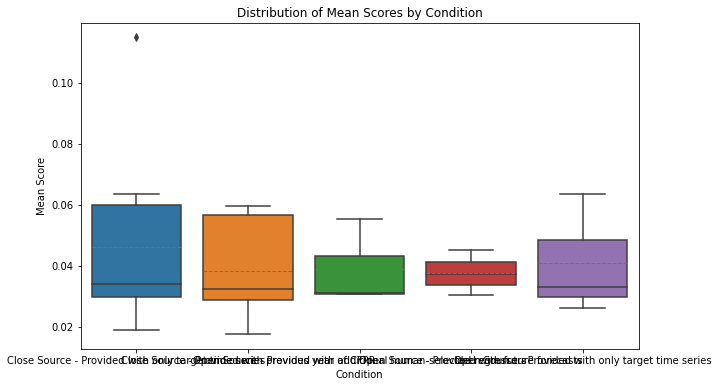

In [93]:
# What if we aggregate across all of the food categories
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Create a boxplot to show the distribution of mean_score across conditions
plt.figure(figsize=(10, 6))
sns.boxplot(data=mape_df, x='inclusion', y='mean_score', showmeans=True, meanline=True)

# Add plot labels and title
plt.title("Distribution of Mean Scores by Condition")
plt.xlabel("Condition")
plt.ylabel("Mean Score")

# Show plot
plt.show()

### By individiual food category

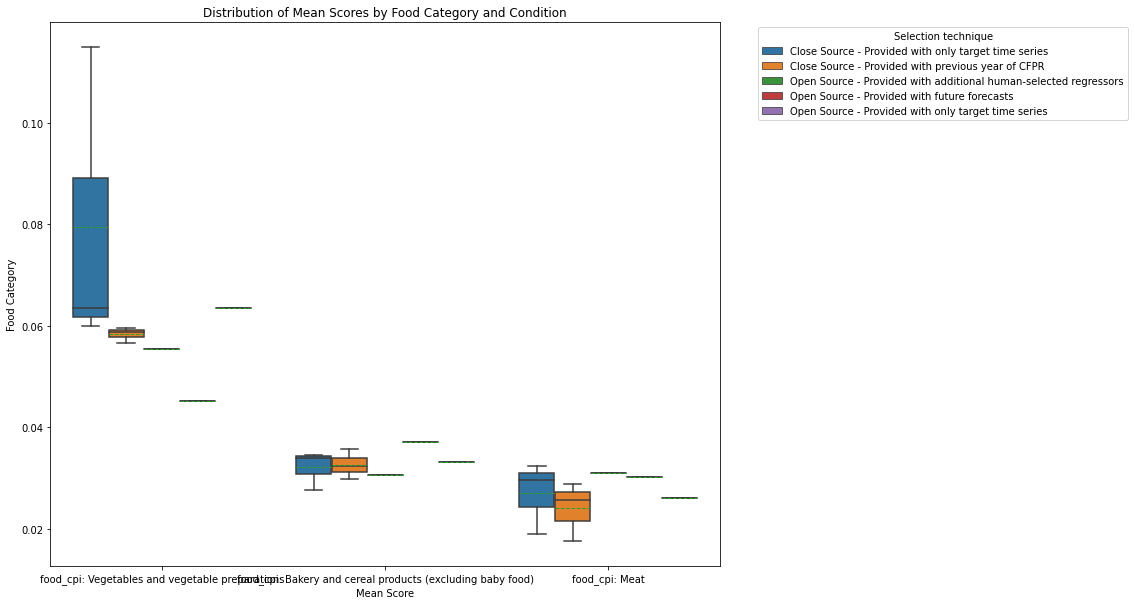

In [94]:

# Set up the plot with category on the y-axis, mean_score on the x-axis, and hue for conditions
plt.figure(figsize=(12, 10))
sns.boxplot(data=mape_df, y='mean_score', x='category', hue='inclusion', showmeans=True, meanline=True)

# Add plot labels and title
plt.title("Distribution of Mean Scores by Food Category and Condition")
plt.xlabel("Mean Score")
plt.ylabel("Food Category")

# Show plot with legend outside
plt.legend(title='Selection technique', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [95]:
mape_df

,year,experiment,category,mean_score,std_score,scores,type,inclusion,selection
26,1986,gpt-4o_report_False,food_cpi: Vegetables and vegetable preparations,0.059866,0.030996,"[0.0846794216248491, 0.02231760183568296, 0.03...",Close Source,Close Source - Provided with only target time ...,None
24,1986,gpt-4o_report_False,food_cpi: Bakery and cereal products (excludin...,0.034011,0.024794,"[0.007227672274065404, 0.011757098041449808, 0...",Close Source,Close Source - Provided with only target time ...,None
23,1986,claude-3-5-sonnet-20240620_report_False,food_cpi: Vegetables and vegetable preparations,0.063445,0.031297,"[0.08808218823687292, 0.08757939702701883, 0.0...",Close Source,Close Source - Provided with only target time ...,None
22,1986,claude-3-5-sonnet-20240620_report_False,food_cpi: Meat,0.019026,0.008880,"[0.02162609988646777, 0.013651991680137948, 0....",Close Source,Close Source - Provided with only target time ...,None
21,1986,claude-3-5-sonnet-20240620_report_False,food_cpi: Bakery and cereal products (excludin...,0.027690,0.015876,"[0.019770663026175018, 0.009294103079105985, 0...",Close Source,Close Source - Provided with only target time ...,None
25,1986,gpt-4o_report_False,food_cpi: Meat,0.032466,0.013774,"[0.023998995146270696, 0.033743482131426625, 0...",Close Source,Close Source - Provided with only target time ...,None
9,1986,gemini-1.5-pro_report_False,food_cpi: Bakery and cereal products (excludin...,0.034633,0.022684,"[0.008456593699308198, 0.01629206489434754, 0....",Close Source,Close Source - Provided with only target time ...,None
10,1986,gemini-1.5-pro_report_False,food_cpi: Meat,0.029668,0.017249,"[0.01111883562520309, 0.01949660442620699, 0.0...",Close Source,Close Source - Provided with only target time ...,None
11,1986,gemini-1.5-pro_report_False,food_cpi: Vegetables and vegetable preparations,0.114920,0.111707,"[0.12405541894408227, 0.018493668807863642, 0....",Close Source,Close Source - Provided with only target time ...,None
20,1986,claude-3-5-sonnet-20240620_report_True,food_cpi: Vegetables and vegetable preparations,0.059625,0.018567,"[0.09137529815939394, 0.06600164775900332, 0.0...",Close Source,Close Source - Provided with previous year of ...,None


In [96]:
# Step 1: Aggregate mean and standard deviation
summary_table = mape_df.groupby(['category', 'inclusion']).agg(
    Mean_Score=('mean_score', 'mean'),
    Std_Deviation=('std_score', 'mean')
).reset_index()

# Step 2: Format the results as "mean ± std"
summary_table['Mean_Std'] = summary_table.apply(
    lambda row: f"{row['Mean_Score']:.3f} ± {row['Std_Deviation']:.3f}", axis=1
)

# Step 3: Pivot the table to have each condition as a column
pivot_table = summary_table.pivot(index='category', columns='inclusion', values='Mean_Std').reset_index()

# Display the pivoted summary table
pivot_table

inclusion,category,Close Source - Provided with only target time series,Close Source - Provided with previous year of CFPR,Open Source - Provided with additional human-selected regressors,Open Source - Provided with future forecasts,Open Source - Provided with only target time series
0,food_cpi: Bakery and cereal products (excludin...,0.032 ± 0.021,0.033 ± 0.021,0.031 ± 0.020,0.037 ± 0.025,0.033 ± 0.019
1,food_cpi: Meat,0.027 ± 0.013,0.024 ± 0.011,0.031 ± 0.015,0.030 ± 0.014,0.026 ± 0.018
2,food_cpi: Vegetables and vegetable preparations,0.079 ± 0.058,0.058 ± 0.021,0.055 ± 0.018,0.045 ± 0.028,0.063 ± 0.012


In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_category(df, category):

    # Assuming `expanded_df` is the DataFrame from the previous step with columns for each evaluation window
    #Set the index to 'experiment' for better visualization
    df.set_index('experiment', inplace=True)
    
    # Select only the columns related to evaluation windows (eval_window_0, eval_window_1, ...)
    eval_columns = [col for col in df.columns if 'eval_window_' in col]

    # Create the heatmap using seaborn
    plt.figure(figsize=(15, 12))  # Adjust the size of the heatmap as needed
    sns.heatmap(df[eval_columns], annot=True, cmap='coolwarm', linewidths=0.5)

    # Set the title and labels
    plt.title(f'Heatmap of Evaluation Window Scores For {category} Across Experiments', fontsize=16)
    plt.xlabel('Evaluation Windows')
    plt.ylabel('Experiment')
    
    plt.savefig(f'../../cfpr_llm/Results_Oct25/{category}.png')

    # Show the heatmap
    plt.show()

In [98]:
# Assuming your DataFrame is named 'df' and the column with MAPE lists is 'scores'
# Create a new DataFrame to store the expanded columns for each evaluation window
expanded_df = pd.DataFrame()

# Loop through each row in the original DataFrame
for index, row in mape_df.iterrows():

# for index, row in mape_df.iterrows():
    mape_list = row['scores']  # Assuming the column with MAPE lists is named 'scores'
    
    # Create a dictionary for the new row
    new_row = {
        'experiment': row['experiment'],    # Retain experiment name
        'category': row['category'],        # Retain category
        'scores': row['scores'],                 # Retain path
        'mean': row['mean_score'],                 # Retain path
        'inclusion': row['inclusion']                 # Retain path

    }
    
    # Add each evaluation window's score as a new column
    for i, score in enumerate(mape_list):
        new_row['eval_window_'+report_sim_dates[i]] = score
    
    # Append the new row to the expanded DataFrame
    expanded_df = expanded_df.append(new_row, ignore_index=True)
expanded_df


/tmp/ipykernel_693/2610854191.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_df = expanded_df.append(new_row, ignore_index=True)
/tmp/ipykernel_693/2610854191.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_df = expanded_df.append(new_row, ignore_index=True)
/tmp/ipykernel_693/2610854191.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_df = expanded_df.append(new_row, ignore_index=True)
/tmp/ipykernel_693/2610854191.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expanded_df = expanded_df.append(new_row, ignore_index=True)
/tmp/ipykernel_693/2610854191.py:26: FutureWarning: The frame.append

,experiment,category,scores,mean,inclusion,eval_window_2018-07-01,eval_window_2019-07-01,eval_window_2020-07-01,eval_window_2021-07-01,eval_window_2022-07-01,eval_window_2023-07-01
0,gpt-4o_report_False,food_cpi: Vegetables and vegetable preparations,"[0.0846794216248491, 0.02231760183568296, 0.03...",0.059866,Close Source - Provided with only target time ...,0.084679,0.022318,0.032669,0.066812,0.111050,0.041667
1,gpt-4o_report_False,food_cpi: Bakery and cereal products (excludin...,"[0.007227672274065404, 0.011757098041449808, 0...",0.034011,Close Source - Provided with only target time ...,0.007228,0.011757,0.024366,0.065702,0.070028,0.024988
2,claude-3-5-sonnet-20240620_report_False,food_cpi: Vegetables and vegetable preparations,"[0.08808218823687292, 0.08757939702701883, 0.0...",0.063445,Close Source - Provided with only target time ...,0.088082,0.087579,0.031337,0.101784,0.054306,0.017583
3,claude-3-5-sonnet-20240620_report_False,food_cpi: Meat,"[0.02162609988646777, 0.013651991680137948, 0....",0.019026,Close Source - Provided with only target time ...,0.021626,0.013652,0.034968,0.015834,0.021891,0.006182
4,claude-3-5-sonnet-20240620_report_False,food_cpi: Bakery and cereal products (excludin...,"[0.019770663026175018, 0.009294103079105985, 0...",0.027690,Close Source - Provided with only target time ...,0.019771,0.009294,0.027295,0.060714,0.024075,0.024988
5,gpt-4o_report_False,food_cpi: Meat,"[0.023998995146270696, 0.033743482131426625, 0...",0.032466,Close Source - Provided with only target time ...,0.023999,0.033743,0.044078,0.043826,0.042969,0.006182
6,gemini-1.5-pro_report_False,food_cpi: Bakery and cereal products (excludin...,"[0.008456593699308198, 0.01629206489434754, 0....",0.034633,Close Source - Provided with only target time ...,0.008457,0.016292,0.050232,0.058142,0.062390,0.012285
7,gemini-1.5-pro_report_False,food_cpi: Meat,"[0.01111883562520309, 0.01949660442620699, 0.0...",0.029668,Close Source - Provided with only target time ...,0.011119,0.019497,0.037036,0.055262,0.045142,0.009950
8,gemini-1.5-pro_report_False,food_cpi: Vegetables and vegetable preparations,"[0.12405541894408227, 0.018493668807863642, 0....",0.114920,Close Source - Provided with only target time ...,0.124055,0.018494,0.353525,0.053967,0.089212,0.050266
9,claude-3-5-sonnet-20240620_report_True,food_cpi: Vegetables and vegetable preparations,"[0.09137529815939394, 0.06600164775900332, 0.0...",0.059625,Close Source - Provided with previous year of ...,0.091375,0.066002,0.032932,0.067749,0.054838,0.044854


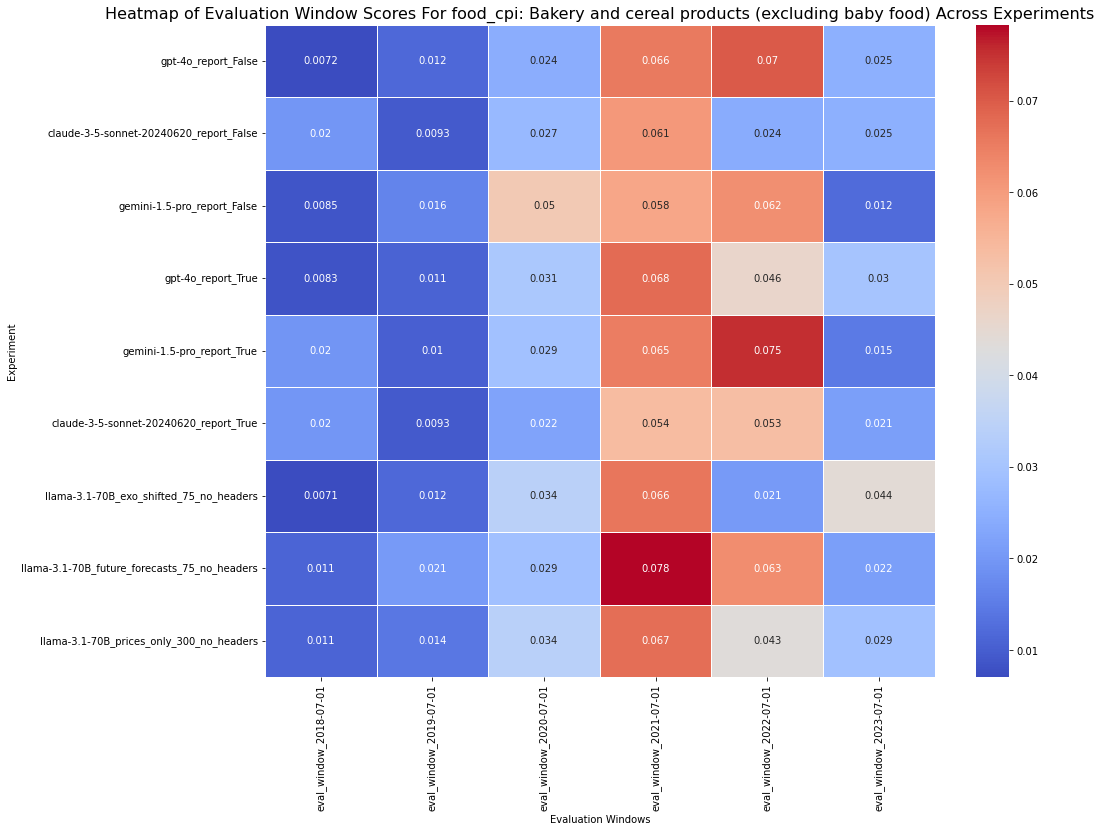

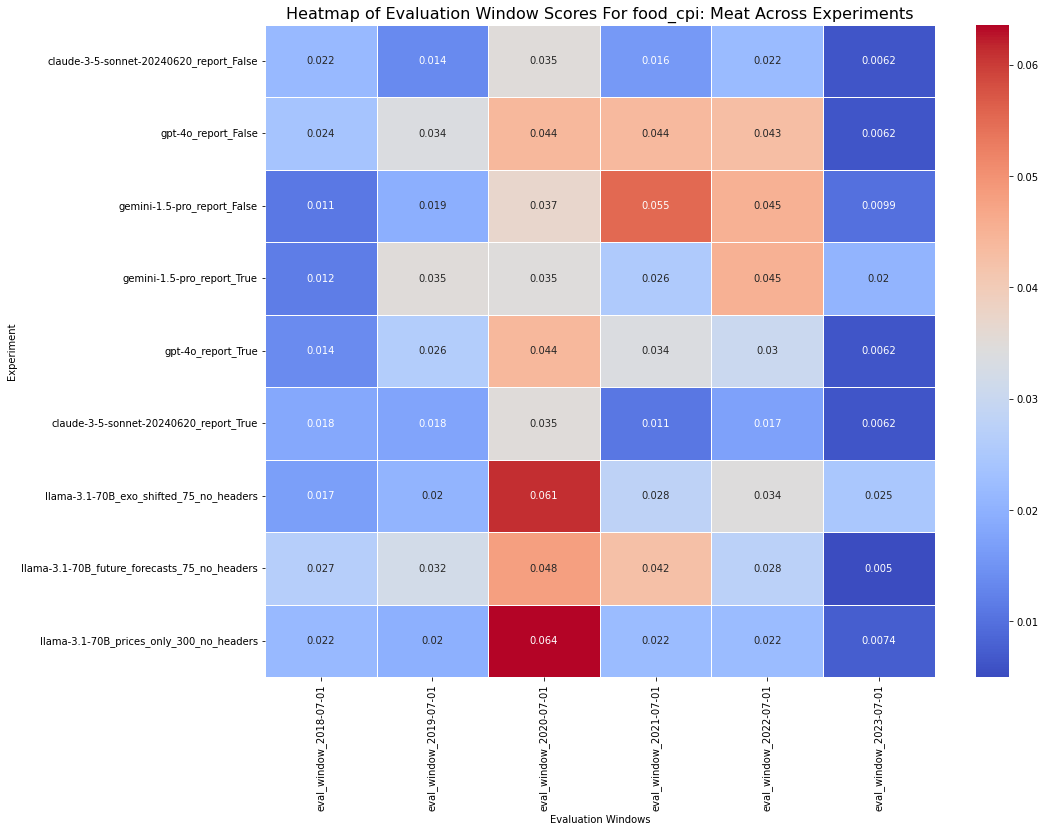

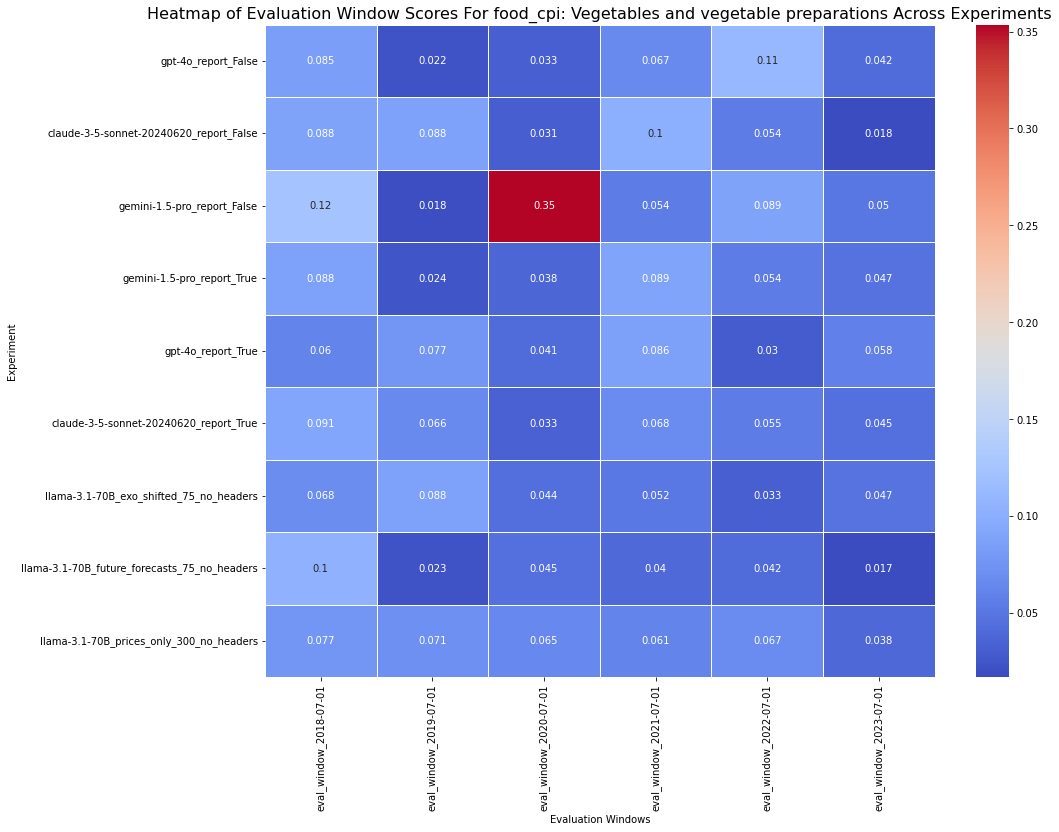

In [99]:
for category in target_categories:
    if 'restaurant' in category:
        continue
    df_filt = expanded_df.sort_values('inclusion').loc[expanded_df['category']==category]
    plot_category(df_filt, category)

In [107]:

def compute_scores_single_ensemble(report_sim_dates, ensemble_experiments, study_metric="mape"):
    """
    This function computes scores for an ensemble of experiments.
    
    Parameters:
    - report_sim_dates: List of simulation dates.
    - ensemble_experiments: A list of experiment names that form the ensemble.
    - study_metric: The metric to be used for scoring ('mape' or 'pinball_loss').
    
    Returns:
    - A DataFrame with results (mean and std scores).
    """
    global forecast_df
    global forecast_dfs
    global actual_df
    results = []

    for start_year in start_years:
        # Join experiment names to track which ensemble is being processed
        experiment_names = '+'.join(ensemble_experiments)
        print(f"Processing ensemble: {experiment_names}")

        if any(name in experiment_names for name in ['llama', 'claude', 'gpt', 'gemini']):
               predicted_categories = [
                'food_cpi: Bakery and cereal products (excluding baby food)',
                'food_cpi: Meat',
                'food_cpi: Vegetables and vegetable preparations'
            ]
        else:
            predicted_categories = target_categories


        for category in predicted_categories:
            scores = []

            for cutoff_date in report_sim_dates:

                # Collect the forecasts for each experiment in the ensemble
                forecast_dfs = []
                for exp_name in ensemble_experiments:
                    forecast_csv_path = f"../generate_forecasts/output/{exp_test_description}/{exp_name}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df = forecast_df[['q_0.05','q_0.95','q_0.5']]
                    forecast_df.index = pd.to_datetime(forecast_df.index)
                    forecast_df = forecast_df.loc[forecast_df.index<='2024-07-01']
                    forecast_dfs.append(forecast_df)

                # Aggregate the forecasts (mean ensemble)
                mean_forecast_values = np.sum([df.values / len(ensemble_experiments) for df in forecast_dfs], axis=0)
                forecast_df = pd.DataFrame(mean_forecast_values, index=forecast_dfs[0].index, columns=forecast_dfs[0].columns)
    
    
#                 # Concatenate DataFrames with alignment on index, filling missing values with NaN
#                 aligned_forecasts = pd.concat(forecast_dfs, axis=1, keys=range(len(forecast_dfs)))

#                 # Calculate the mean for each quantile, ignoring NaN values
#                 mean_q_0_05 = aligned_forecasts.xs('q_0.05', axis=1, level=1).mean(axis=1)
#                 mean_q_0_5 = aligned_forecasts.xs('q_0.5', axis=1, level=1).mean(axis=1)
#                 mean_q_0_95 = aligned_forecasts.xs('q_0.95', axis=1, level=1).mean(axis=1)

#                 # Combine the means back into a single DataFrame
#                 mean_forecast_df = pd.DataFrame({
#                     'q_0.05': mean_q_0_05,
#                     'q_0.5': mean_q_0_5,
#                     'q_0.95': mean_q_0_95
#                 })    
                
#                 forecast_df = pd.DataFrame(mean_forecast_df, index=forecast_dfs[0].index, columns=forecast_dfs[0].columns)

                # Extract the actual values from the foodprice_df
                actual_df = foodprice_df[category].loc[
                    [
                        date
                        for date in forecast_df.index
                        if date in foodprice_df.index
                    ]
                ]

                # Handle the case where the forecast and actual data have different lengths
                if report_sim_dates[-1] == cutoff_date:
                    forecast_df = forecast_df.iloc[:-1]
                    actual_df = actual_df.iloc[:-1]
      

                # Score the aggregated forecast using the specified metric
                if study_metric in point_metrics:
                    median_col = "q_0.5"
                    y_pred = forecast_df[median_col]
                    y_true = actual_df
                    if len(y_pred) > len(y_true):
                        y_pred = y_pred[: len(y_true)]
                    scores.append(
                        point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                    )

            # Calculate mean and std deviation of the scores
            mean_score = np.mean(scores)
            std_score = np.std(scores)

            # Append the result for the current category and ensemble configuration
            results.append(
                {
                    "year": start_year,
                    "experiment": experiment_names,
                    "category": category,
                    "mean_score": mean_score,
                    "std_score": std_score,
                    "scores": scores
                }
            )

    # Return the result as a DataFrame
    return pd.DataFrame(results)



In [108]:
from itertools import combinations
from tqdm import tqdm

all_exp_results = []

for category in foodprice_df.columns:
    print(f"Computing ensemble scores for: {category}")
    all_combinations = []

    # Iterate through combinations of experiments for the ensemble (from 1 to 5 experiments in ensemble)
    for r in range(1, 3):
        # Select top 10 experiments based on lowest mean_score for the specific category
        top_experiments = mape_df.loc[mape_df.category == category].sort_values('mean_score').head(10)['experiment']

        # Generate all combinations of the experiments for this category
        exp_combinations = combinations(top_experiments, r)
        all_combinations.extend(exp_combinations)

    exp_results = []
    
    # Iterate over each unique experiment configuration (combination of experiments)
    for exp_config in tqdm(set(all_combinations)):
        # Call the compute_scores_single_ensemble function with each combination of experiments
        exp_results.append(
            compute_scores_single_ensemble(
                report_sim_dates=report_sim_dates,  # Use your date range here
                ensemble_experiments=list(exp_config),  # Pass current combination of experiments
                study_metric="mape"  # or another metric if needed
            )
        )
    
    # Extend the results across all categories
    all_exp_results.extend(exp_results)

Computing ensemble scores for: food_cpi: Bakery and cereal products (excluding baby food)


  0%|          | 0/255 [00:00<?, ?it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


  0%|          | 1/255 [00:00<01:06,  3.81it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_True


  1%|          | 3/255 [00:00<01:01,  4.10it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers


  2%|▏         | 5/255 [00:01<00:49,  5.08it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


  2%|▏         | 6/255 [00:01<00:53,  4.63it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


  3%|▎         | 7/255 [00:01<00:56,  4.38it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False


  3%|▎         | 8/255 [00:01<00:59,  4.18it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


  4%|▎         | 9/255 [00:02<00:59,  4.11it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


  4%|▍         | 11/255 [00:02<00:56,  4.34it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_False


  5%|▍         | 12/255 [00:02<00:50,  4.85it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_True


  5%|▌         | 14/255 [00:03<00:51,  4.70it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gemini-1.5-pro_report_False


  6%|▌         | 15/255 [00:03<00:49,  4.81it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gpt-4o_report_False


  7%|▋         | 17/255 [00:03<00:50,  4.69it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers


  7%|▋         | 18/255 [00:04<00:53,  4.40it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False


  7%|▋         | 19/255 [00:04<00:55,  4.25it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


  8%|▊         | 21/255 [00:04<00:53,  4.41it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


  9%|▉         | 23/255 [00:05<00:51,  4.51it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True


 10%|▉         | 25/255 [00:05<00:48,  4.77it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 10%|█         | 26/255 [00:05<00:43,  5.25it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 11%|█         | 27/255 [00:06<00:54,  4.18it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 11%|█▏        | 29/255 [00:06<00:48,  4.67it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True
Processing ensemble: gpt-4o_report_False+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 12%|█▏        | 30/255 [00:06<00:52,  4.27it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 13%|█▎        | 32/255 [00:07<00:49,  4.47it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False


 13%|█▎        | 34/255 [00:07<00:43,  5.04it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 14%|█▍        | 36/255 [00:07<00:43,  5.02it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True


 15%|█▍        | 37/255 [00:08<00:43,  5.04it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False


 15%|█▍        | 38/255 [00:08<00:46,  4.63it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 15%|█▌        | 39/255 [00:08<00:49,  4.39it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 16%|█▌        | 40/255 [00:08<00:50,  4.25it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True


 16%|█▌        | 41/255 [00:09<00:51,  4.17it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 16%|█▋        | 42/255 [00:09<00:52,  4.08it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 17%|█▋        | 43/255 [00:09<00:52,  4.06it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_False


 18%|█▊        | 45/255 [00:10<00:48,  4.30it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 18%|█▊        | 47/255 [00:10<00:42,  4.95it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_False


 19%|█▉        | 48/255 [00:10<00:45,  4.58it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gpt-4o_report_False


 19%|█▉        | 49/255 [00:10<00:47,  4.33it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 20%|█▉        | 50/255 [00:11<00:48,  4.20it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 20%|██        | 51/255 [00:11<00:49,  4.13it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 21%|██        | 53/255 [00:11<00:46,  4.32it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 21%|██        | 54/255 [00:12<00:44,  4.54it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gemini-1.5-pro_report_True


 22%|██▏       | 56/255 [00:12<00:40,  4.86it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 23%|██▎       | 58/255 [00:12<00:39,  4.96it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 24%|██▎       | 60/255 [00:13<00:39,  4.94it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_False+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 24%|██▍       | 62/255 [00:13<00:40,  4.74it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: gpt-4o_report_False+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 25%|██▌       | 64/255 [00:14<00:38,  4.91it/s]

Processing ensemble: gpt-4o_report_False+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 26%|██▌       | 66/255 [00:14<00:40,  4.72it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 26%|██▋       | 67/255 [00:14<00:42,  4.46it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 27%|██▋       | 69/255 [00:15<00:38,  4.84it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 27%|██▋       | 70/255 [00:15<00:40,  4.53it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


 28%|██▊       | 71/255 [00:15<00:42,  4.36it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 28%|██▊       | 72/255 [00:16<00:43,  4.20it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 29%|██▊       | 73/255 [00:16<00:43,  4.14it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 29%|██▉       | 75/255 [00:16<00:41,  4.34it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True


 30%|███       | 77/255 [00:17<00:37,  4.79it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True


 31%|███       | 78/255 [00:17<00:36,  4.81it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False


 31%|███▏      | 80/255 [00:17<00:37,  4.67it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 32%|███▏      | 81/255 [00:18<00:39,  4.39it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 32%|███▏      | 82/255 [00:18<00:40,  4.27it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_True


 33%|███▎      | 84/255 [00:18<00:39,  4.38it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers


 34%|███▎      | 86/255 [00:19<00:38,  4.42it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_True


 35%|███▍      | 88/255 [00:19<00:40,  4.14it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 35%|███▍      | 89/255 [00:20<00:40,  4.05it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 35%|███▌      | 90/255 [00:20<00:40,  4.04it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gemini-1.5-pro_report_False


 36%|███▌      | 91/255 [00:20<00:41,  4.00it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 36%|███▌      | 92/255 [00:20<00:40,  3.99it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 37%|███▋      | 94/255 [00:21<00:37,  4.27it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True
Processing ensemble: gpt-4o_report_False+gemini-1.5-pro_report_False


 37%|███▋      | 95/255 [00:21<00:33,  4.82it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 38%|███▊      | 96/255 [00:21<00:34,  4.59it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False


 38%|███▊      | 97/255 [00:21<00:35,  4.42it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_False+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 38%|███▊      | 98/255 [00:22<00:36,  4.30it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 39%|███▉      | 99/255 [00:22<00:36,  4.22it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_False+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 40%|███▉      | 101/255 [00:22<00:34,  4.43it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 40%|████      | 102/255 [00:22<00:30,  5.01it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_True


 41%|████      | 105/255 [00:23<00:26,  5.62it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True
Processing ensemble: gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 42%|████▏     | 107/255 [00:23<00:25,  5.76it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 42%|████▏     | 108/255 [00:23<00:28,  5.19it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 43%|████▎     | 109/255 [00:24<00:30,  4.84it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True


 43%|████▎     | 110/255 [00:24<00:31,  4.57it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 44%|████▎     | 111/255 [00:24<00:32,  4.37it/s]

Processing ensemble: gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 44%|████▍     | 113/255 [00:25<00:29,  4.82it/s]

Processing ensemble: gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


 45%|████▌     | 115/255 [00:25<00:28,  4.92it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_True


 46%|████▌     | 117/255 [00:25<00:27,  5.03it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


 47%|████▋     | 119/255 [00:26<00:28,  4.83it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: gemini-1.5-pro_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 47%|████▋     | 121/255 [00:26<00:24,  5.41it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True
Processing ensemble: gpt-4o_report_True


 48%|████▊     | 123/255 [00:26<00:19,  6.69it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True


 49%|████▊     | 124/255 [00:27<00:22,  5.73it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


 49%|████▉     | 125/255 [00:27<00:25,  5.20it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 49%|████▉     | 126/255 [00:27<00:26,  4.86it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 50%|████▉     | 127/255 [00:27<00:27,  4.66it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True


 50%|█████     | 128/255 [00:28<00:28,  4.43it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False


 51%|█████     | 129/255 [00:28<00:29,  4.28it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 51%|█████▏    | 131/255 [00:28<00:27,  4.46it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False


 52%|█████▏    | 133/255 [00:29<00:24,  4.92it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers


 53%|█████▎    | 135/255 [00:29<00:23,  5.03it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gemini-1.5-pro_report_True
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 54%|█████▎    | 137/255 [00:30<00:22,  5.19it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 55%|█████▍    | 140/255 [00:30<00:20,  5.58it/s]

Processing ensemble: gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 55%|█████▌    | 141/255 [00:30<00:22,  5.02it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_True


 56%|█████▌    | 143/255 [00:31<00:23,  4.86it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 57%|█████▋    | 145/255 [00:31<00:22,  4.99it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers


 57%|█████▋    | 146/255 [00:31<00:21,  5.05it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True
Processing ensemble: gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 58%|█████▊    | 148/255 [00:32<00:17,  6.23it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 58%|█████▊    | 149/255 [00:32<00:19,  5.50it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False


 59%|█████▉    | 151/255 [00:32<00:20,  5.05it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True


 60%|█████▉    | 152/255 [00:32<00:21,  4.73it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 60%|██████    | 153/255 [00:33<00:22,  4.51it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 61%|██████    | 155/255 [00:33<00:20,  4.89it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 62%|██████▏   | 157/255 [00:33<00:19,  5.02it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True


 62%|██████▏   | 159/255 [00:34<00:16,  5.94it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers


 63%|██████▎   | 160/255 [00:34<00:16,  5.70it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False


 63%|██████▎   | 161/255 [00:34<00:18,  5.06it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gpt-4o_report_False


 64%|██████▎   | 162/255 [00:34<00:19,  4.72it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 64%|██████▍   | 164/255 [00:35<00:19,  4.63it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gpt-4o_report_False


 65%|██████▌   | 166/255 [00:35<00:16,  5.29it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers


 66%|██████▌   | 168/255 [00:36<00:14,  5.97it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 67%|██████▋   | 170/255 [00:36<00:15,  5.59it/s]

Processing ensemble: gpt-4o_report_True+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_True


 67%|██████▋   | 171/255 [00:36<00:16,  5.06it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 67%|██████▋   | 172/255 [00:36<00:17,  4.71it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 68%|██████▊   | 173/255 [00:37<00:18,  4.49it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 68%|██████▊   | 174/255 [00:37<00:18,  4.32it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_True


 69%|██████▉   | 176/255 [00:37<00:16,  4.84it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_True


 69%|██████▉   | 177/255 [00:38<00:17,  4.58it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 70%|███████   | 179/255 [00:38<00:15,  5.02it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True


 71%|███████   | 180/255 [00:38<00:13,  5.51it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 71%|███████   | 181/255 [00:38<00:14,  4.95it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True


 71%|███████▏  | 182/255 [00:39<00:15,  4.64it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False


 72%|███████▏  | 183/255 [00:39<00:16,  4.46it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 73%|███████▎  | 185/255 [00:39<00:15,  4.56it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 73%|███████▎  | 187/255 [00:40<00:14,  4.59it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers


 74%|███████▎  | 188/255 [00:40<00:12,  5.17it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False


 75%|███████▍  | 190/255 [00:40<00:13,  4.86it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 75%|███████▌  | 192/255 [00:41<00:13,  4.76it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_True


 76%|███████▌  | 194/255 [00:41<00:12,  4.70it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_False


 77%|███████▋  | 196/255 [00:42<00:12,  4.73it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True
Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_True


 78%|███████▊  | 198/255 [00:42<00:11,  4.95it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+gemini-1.5-pro_report_True


 78%|███████▊  | 199/255 [00:42<00:12,  4.64it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 78%|███████▊  | 200/255 [00:42<00:12,  4.41it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 79%|███████▉  | 202/255 [00:43<00:11,  4.59it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers


 80%|███████▉  | 203/255 [00:43<00:11,  4.42it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gemini-1.5-pro_report_False


 80%|████████  | 204/255 [00:43<00:11,  4.29it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 80%|████████  | 205/255 [00:44<00:11,  4.18it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False


 81%|████████  | 207/255 [00:44<00:11,  4.27it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers


 82%|████████▏ | 208/255 [00:44<00:09,  4.86it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 82%|████████▏ | 209/255 [00:44<00:10,  4.57it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers


 82%|████████▏ | 210/255 [00:45<00:10,  4.43it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 83%|████████▎ | 211/255 [00:45<00:10,  4.27it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 83%|████████▎ | 212/255 [00:45<00:10,  4.22it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 84%|████████▎ | 213/255 [00:45<00:10,  4.15it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 84%|████████▍ | 215/255 [00:46<00:09,  4.39it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_False+gemini-1.5-pro_report_False


 85%|████████▌ | 217/255 [00:46<00:08,  4.74it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_False


 85%|████████▌ | 218/255 [00:46<00:06,  5.30it/s]

Processing ensemble: gpt-4o_report_False
Processing ensemble: gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 87%|████████▋ | 221/255 [00:47<00:05,  6.10it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 87%|████████▋ | 222/255 [00:47<00:06,  5.39it/s]

Processing ensemble: gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 87%|████████▋ | 223/255 [00:47<00:06,  4.80it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 88%|████████▊ | 224/255 [00:48<00:07,  4.03it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False


 89%|████████▊ | 226/255 [00:48<00:06,  4.43it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 89%|████████▉ | 227/255 [00:48<00:06,  4.29it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gemini-1.5-pro_report_True


 90%|████████▉ | 229/255 [00:49<00:05,  4.78it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 91%|█████████ | 231/255 [00:49<00:04,  5.07it/s]

Processing ensemble: gpt-4o_report_False+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gpt-4o_report_False


 91%|█████████▏| 233/255 [00:50<00:04,  5.10it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 92%|█████████▏| 234/255 [00:50<00:04,  5.10it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 93%|█████████▎| 236/255 [00:50<00:03,  5.07it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_True


 93%|█████████▎| 237/255 [00:50<00:03,  4.71it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False


 93%|█████████▎| 238/255 [00:51<00:03,  4.49it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False
Processing ensemble: gpt-4o_report_True+gpt-4o_report_False


 94%|█████████▍| 240/255 [00:51<00:02,  5.82it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 95%|█████████▍| 241/255 [00:51<00:02,  5.26it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


 95%|█████████▍| 242/255 [00:51<00:02,  4.87it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 95%|█████████▌| 243/255 [00:52<00:02,  4.59it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 96%|█████████▌| 244/255 [00:52<00:02,  4.41it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_False+gemini-1.5-pro_report_True


 96%|█████████▌| 245/255 [00:52<00:02,  4.32it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True


 97%|█████████▋| 247/255 [00:53<00:01,  4.80it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 98%|█████████▊| 249/255 [00:53<00:01,  4.70it/s]

Processing ensemble: gpt-4o_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_True


 98%|█████████▊| 250/255 [00:53<00:01,  4.83it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 98%|█████████▊| 251/255 [00:53<00:00,  4.43it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers


 99%|█████████▉| 252/255 [00:54<00:00,  3.95it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_False


 99%|█████████▉| 253/255 [00:54<00:00,  3.87it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


100%|██████████| 255/255 [00:54<00:00,  4.65it/s]


Processing ensemble: gemini-1.5-pro_report_False
Computing ensemble scores for: food_cpi: Meat


  0%|          | 0/255 [00:00<?, ?it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


  0%|          | 1/255 [00:00<00:51,  4.97it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


  1%|          | 3/255 [00:00<00:53,  4.68it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers


  2%|▏         | 4/255 [00:00<00:51,  4.85it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False


  2%|▏         | 6/255 [00:01<00:48,  5.14it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_False+gpt-4o_report_False


  3%|▎         | 8/255 [00:01<00:50,  4.85it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


  4%|▎         | 9/255 [00:01<00:49,  4.95it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


  4%|▍         | 11/255 [00:02<00:46,  5.20it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


  5%|▍         | 12/255 [00:02<00:50,  4.77it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


  5%|▌         | 13/255 [00:02<00:54,  4.46it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


  5%|▌         | 14/255 [00:03<00:55,  4.34it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


  6%|▋         | 16/255 [00:03<00:53,  4.44it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


  7%|▋         | 17/255 [00:03<00:55,  4.30it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers


  7%|▋         | 19/255 [00:04<00:52,  4.46it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


  8%|▊         | 20/255 [00:04<00:54,  4.31it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False


  8%|▊         | 21/255 [00:04<00:55,  4.22it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


  9%|▉         | 23/255 [00:05<00:52,  4.39it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False
Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers


  9%|▉         | 24/255 [00:05<00:54,  4.22it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False


 10%|▉         | 25/255 [00:05<00:55,  4.13it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 10%|█         | 26/255 [00:05<00:56,  4.05it/s]

Processing ensemble: gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 11%|█         | 28/255 [00:06<00:52,  4.30it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True+gpt-4o_report_False
Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 12%|█▏        | 30/255 [00:06<00:50,  4.45it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True
Processing ensemble: gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 13%|█▎        | 32/255 [00:07<00:43,  5.18it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 13%|█▎        | 33/255 [00:07<00:42,  5.16it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 14%|█▎        | 35/255 [00:07<00:44,  4.91it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_False


 14%|█▍        | 36/255 [00:07<00:47,  4.59it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 15%|█▍        | 37/255 [00:08<00:54,  4.03it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers


 15%|█▍        | 38/255 [00:08<00:53,  4.05it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 15%|█▌        | 39/255 [00:08<00:53,  4.02it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 16%|█▌        | 40/255 [00:09<00:59,  3.60it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 16%|█▌        | 41/255 [00:09<00:58,  3.64it/s]

Processing ensemble: gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 16%|█▋        | 42/255 [00:09<00:55,  3.84it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers


 17%|█▋        | 43/255 [00:09<00:54,  3.91it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 17%|█▋        | 44/255 [00:10<00:53,  3.94it/s]

Processing ensemble: gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 18%|█▊        | 46/255 [00:10<00:49,  4.26it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False+gpt-4o_report_False
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 19%|█▉        | 48/255 [00:10<00:41,  4.93it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_True+gpt-4o_report_False
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True


 19%|█▉        | 49/255 [00:11<00:38,  5.42it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 20%|█▉        | 50/255 [00:11<00:41,  4.93it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 20%|██        | 52/255 [00:11<00:42,  4.80it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 21%|██        | 54/255 [00:12<00:40,  4.94it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False+gpt-4o_report_False


 22%|██▏       | 56/255 [00:12<00:40,  4.88it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False


 22%|██▏       | 57/255 [00:12<00:39,  4.97it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 23%|██▎       | 59/255 [00:13<00:40,  4.80it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False


 24%|██▎       | 60/255 [00:13<00:44,  4.42it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_False


 24%|██▍       | 61/255 [00:13<00:46,  4.13it/s]

Processing ensemble: gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 24%|██▍       | 62/255 [00:13<00:46,  4.13it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False


 25%|██▍       | 63/255 [00:14<00:44,  4.31it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 25%|██▌       | 64/255 [00:14<00:45,  4.24it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+gpt-4o_report_False


 25%|██▌       | 65/255 [00:14<00:46,  4.07it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 26%|██▋       | 67/255 [00:15<00:40,  4.65it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 27%|██▋       | 68/255 [00:15<00:42,  4.43it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False


 27%|██▋       | 69/255 [00:15<00:43,  4.31it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers


 27%|██▋       | 70/255 [00:15<00:44,  4.20it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False


 28%|██▊       | 71/255 [00:16<00:44,  4.12it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers


 29%|██▊       | 73/255 [00:16<00:41,  4.39it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+gpt-4o_report_False
Processing ensemble: gemini-1.5-pro_report_True+gemini-1.5-pro_report_False


 29%|██▉       | 74/255 [00:16<00:36,  4.94it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers


 29%|██▉       | 75/255 [00:16<00:38,  4.63it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 30%|███       | 77/255 [00:17<00:38,  4.60it/s]

Processing ensemble: gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+gpt-4o_report_False


 31%|███       | 78/255 [00:17<00:40,  4.41it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 31%|███       | 79/255 [00:17<00:40,  4.30it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_True


 31%|███▏      | 80/255 [00:18<00:41,  4.22it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+gpt-4o_report_False


 32%|███▏      | 81/255 [00:18<00:41,  4.18it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 33%|███▎      | 83/255 [00:18<00:36,  4.71it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_False
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False


 33%|███▎      | 84/255 [00:18<00:35,  4.85it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 33%|███▎      | 85/255 [00:19<00:37,  4.57it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers


 34%|███▍      | 87/255 [00:19<00:36,  4.60it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 35%|███▍      | 88/255 [00:19<00:34,  4.78it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 35%|███▍      | 89/255 [00:20<00:36,  4.49it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 35%|███▌      | 90/255 [00:20<00:37,  4.36it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 36%|███▌      | 91/255 [00:20<00:38,  4.25it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False


 36%|███▌      | 92/255 [00:20<00:38,  4.18it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers


 37%|███▋      | 94/255 [00:21<00:36,  4.39it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers


 38%|███▊      | 96/255 [00:21<00:35,  4.49it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 38%|███▊      | 98/255 [00:22<00:32,  4.77it/s]

Processing ensemble: gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 39%|███▉      | 99/255 [00:22<00:34,  4.51it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 39%|███▉      | 100/255 [00:22<00:35,  4.34it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 40%|████      | 102/255 [00:22<00:31,  4.83it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 41%|████      | 104/255 [00:23<00:32,  4.72it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_exo_shifted_75_no_headers


 41%|████      | 105/255 [00:23<00:31,  4.83it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers


 42%|████▏     | 106/255 [00:23<00:34,  4.32it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 42%|████▏     | 107/255 [00:24<00:39,  3.72it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 42%|████▏     | 108/255 [00:24<00:39,  3.72it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_False


 43%|████▎     | 109/255 [00:24<00:38,  3.81it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+gpt-4o_report_False


 43%|████▎     | 110/255 [00:25<00:37,  3.89it/s]

Processing ensemble: gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 44%|████▍     | 112/255 [00:25<00:33,  4.22it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 44%|████▍     | 113/255 [00:25<00:29,  4.82it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_True


 45%|████▌     | 116/255 [00:26<00:25,  5.51it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True
Processing ensemble: gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 46%|████▋     | 118/255 [00:26<00:23,  5.72it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+gpt-4o_report_False


 47%|████▋     | 120/255 [00:26<00:26,  5.19it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers


 47%|████▋     | 121/255 [00:27<00:27,  4.82it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 48%|████▊     | 122/255 [00:27<00:29,  4.56it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 48%|████▊     | 123/255 [00:27<00:30,  4.36it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 49%|████▉     | 125/255 [00:28<00:29,  4.44it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers


 49%|████▉     | 126/255 [00:28<00:25,  5.00it/s]

Processing ensemble: gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 50%|████▉     | 127/255 [00:28<00:27,  4.65it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 51%|█████     | 129/255 [00:28<00:27,  4.60it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 51%|█████▏    | 131/255 [00:29<00:27,  4.55it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 52%|█████▏    | 133/255 [00:29<00:26,  4.58it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 53%|█████▎    | 134/255 [00:30<00:27,  4.38it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers


 53%|█████▎    | 135/255 [00:30<00:28,  4.25it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 54%|█████▎    | 137/255 [00:30<00:25,  4.70it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True
Processing ensemble: gpt-4o_report_True


 55%|█████▍    | 139/255 [00:30<00:19,  5.97it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 55%|█████▍    | 140/255 [00:31<00:20,  5.72it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_True+gpt-4o_report_False


 55%|█████▌    | 141/255 [00:31<00:22,  5.13it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 56%|█████▌    | 142/255 [00:31<00:23,  4.75it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True


 56%|█████▌    | 143/255 [00:31<00:24,  4.50it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 56%|█████▋    | 144/255 [00:32<00:25,  4.34it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+gpt-4o_report_False


 57%|█████▋    | 145/255 [00:32<00:26,  4.22it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_exo_shifted_75_no_headers


 57%|█████▋    | 146/255 [00:32<00:29,  3.71it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 58%|█████▊    | 148/255 [00:33<00:27,  3.83it/s]

Processing ensemble: gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers


 59%|█████▉    | 150/255 [00:33<00:22,  4.72it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers


 60%|█████▉    | 152/255 [00:33<00:18,  5.56it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 60%|██████    | 153/255 [00:34<00:18,  5.41it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 61%|██████    | 155/255 [00:34<00:18,  5.32it/s]

Processing ensemble: gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 61%|██████    | 156/255 [00:34<00:20,  4.84it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 62%|██████▏   | 158/255 [00:35<00:20,  4.71it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 63%|██████▎   | 160/255 [00:35<00:20,  4.62it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers


 63%|██████▎   | 161/255 [00:35<00:21,  4.37it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 64%|██████▍   | 164/255 [00:36<00:18,  4.98it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_False+gpt-4o_report_False


 65%|██████▍   | 165/255 [00:36<00:19,  4.69it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 65%|██████▌   | 167/255 [00:37<00:18,  4.64it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 66%|██████▋   | 169/255 [00:37<00:16,  5.16it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False
Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 67%|██████▋   | 171/255 [00:37<00:15,  5.28it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 67%|██████▋   | 172/255 [00:38<00:17,  4.82it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers


 68%|██████▊   | 173/255 [00:38<00:18,  4.49it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False


 68%|██████▊   | 174/255 [00:38<00:18,  4.31it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 69%|██████▊   | 175/255 [00:38<00:18,  4.22it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False


 69%|██████▉   | 177/255 [00:39<00:17,  4.37it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers


 70%|██████▉   | 178/255 [00:39<00:15,  4.95it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 71%|███████   | 181/255 [00:39<00:13,  5.57it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False
Processing ensemble: gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 71%|███████▏  | 182/255 [00:40<00:13,  5.42it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 72%|███████▏  | 184/255 [00:40<00:14,  4.88it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gpt-4o_report_False


 73%|███████▎  | 186/255 [00:41<00:15,  4.57it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True


 74%|███████▎  | 188/255 [00:41<00:12,  5.53it/s]

Processing ensemble: gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers


 74%|███████▍  | 189/255 [00:41<00:13,  4.91it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 75%|███████▍  | 190/255 [00:41<00:14,  4.56it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 75%|███████▌  | 192/255 [00:42<00:13,  4.57it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers


 76%|███████▌  | 193/255 [00:42<00:13,  4.71it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 76%|███████▋  | 195/255 [00:42<00:12,  4.99it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 77%|███████▋  | 197/255 [00:43<00:10,  5.47it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+gpt-4o_report_False


 78%|███████▊  | 199/255 [00:43<00:11,  4.97it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gpt-4o_report_False
Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 78%|███████▊  | 200/255 [00:43<00:11,  5.00it/s]

Processing ensemble: gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 79%|███████▉  | 202/255 [00:44<00:11,  4.78it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 80%|████████  | 204/255 [00:44<00:09,  5.32it/s]

Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_True
Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers


 81%|████████  | 206/255 [00:45<00:09,  5.18it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True
Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_False+gpt-4o_report_False


 82%|████████▏ | 208/255 [00:45<00:08,  5.61it/s]

Processing ensemble: gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 82%|████████▏ | 209/255 [00:45<00:09,  5.01it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False+llama-3.1-70B_exo_shifted_75_no_headers


 83%|████████▎ | 211/255 [00:46<00:09,  4.78it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False


 84%|████████▎ | 213/255 [00:46<00:08,  5.09it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers


 84%|████████▍ | 214/255 [00:46<00:08,  4.69it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 85%|████████▍ | 216/255 [00:47<00:08,  4.65it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gpt-4o_report_False
Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gpt-4o_report_False


 85%|████████▌ | 218/255 [00:47<00:07,  5.28it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_False
Processing ensemble: gpt-4o_report_False


 86%|████████▋ | 220/255 [00:47<00:05,  5.98it/s]

Processing ensemble: gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_False


 87%|████████▋ | 221/255 [00:48<00:06,  5.34it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 87%|████████▋ | 222/255 [00:48<00:06,  4.81it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False


 87%|████████▋ | 223/255 [00:48<00:07,  4.56it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 88%|████████▊ | 225/255 [00:49<00:06,  4.90it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 89%|████████▉ | 227/255 [00:49<00:05,  5.46it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_False


 89%|████████▉ | 228/255 [00:49<00:04,  5.87it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_True+gpt-4o_report_False


 90%|████████▉ | 229/255 [00:49<00:05,  4.97it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 91%|█████████ | 231/255 [00:50<00:05,  4.70it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True


 91%|█████████▏| 233/255 [00:50<00:04,  5.01it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 92%|█████████▏| 234/255 [00:50<00:04,  4.67it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 92%|█████████▏| 235/255 [00:51<00:04,  4.44it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 93%|█████████▎| 238/255 [00:51<00:03,  5.34it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: gpt-4o_report_True+gpt-4o_report_False


 94%|█████████▎| 239/255 [00:51<00:02,  5.71it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers


 94%|█████████▍| 240/255 [00:51<00:02,  5.09it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


 95%|█████████▍| 241/255 [00:52<00:02,  4.74it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+gemini-1.5-pro_report_True+gpt-4o_report_False


 95%|█████████▌| 243/255 [00:52<00:02,  4.68it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_False+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True


 96%|█████████▌| 245/255 [00:53<00:01,  5.05it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 96%|█████████▋| 246/255 [00:53<00:01,  4.71it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers


 97%|█████████▋| 248/255 [00:53<00:01,  4.89it/s]

Processing ensemble: gemini-1.5-pro_report_False+gpt-4o_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False+gpt-4o_report_False


 98%|█████████▊| 249/255 [00:54<00:01,  3.85it/s]

Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 98%|█████████▊| 250/255 [00:54<00:01,  3.66it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_True+gemini-1.5-pro_report_False


 98%|█████████▊| 251/255 [00:54<00:01,  3.53it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 99%|█████████▉| 252/255 [00:54<00:00,  3.53it/s]

Processing ensemble: gemini-1.5-pro_report_False
Processing ensemble: gemini-1.5-pro_report_True+gemini-1.5-pro_report_False+llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers


100%|██████████| 255/255 [00:55<00:00,  4.59it/s]


Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_True+llama-3.1-70B_exo_shifted_75_no_headers
Computing ensemble scores for: food_cpi: Vegetables and vegetable preparations


  0%|          | 0/255 [00:00<?, ?it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


  0%|          | 1/255 [00:00<01:04,  3.94it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers


  1%|          | 3/255 [00:00<00:57,  4.39it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


  2%|▏         | 5/255 [00:01<00:51,  4.81it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False


  2%|▏         | 6/255 [00:01<00:51,  4.87it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


  3%|▎         | 7/255 [00:01<00:54,  4.53it/s]

Processing ensemble: gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


  4%|▎         | 9/255 [00:01<00:50,  4.89it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False
Processing ensemble: gpt-4o_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


  4%|▍         | 11/255 [00:02<00:51,  4.70it/s]

Processing ensemble: gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False


  5%|▍         | 12/255 [00:02<00:46,  5.20it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True


  5%|▌         | 14/255 [00:02<00:49,  4.84it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False
Processing ensemble: gpt-4o_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers


  6%|▌         | 15/255 [00:03<00:49,  4.90it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


  7%|▋         | 17/255 [00:03<00:50,  4.69it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


  7%|▋         | 19/255 [00:04<00:47,  5.00it/s]

Processing ensemble: gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_False


  8%|▊         | 21/255 [00:04<00:46,  5.07it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


  9%|▊         | 22/255 [00:04<00:46,  5.06it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers


  9%|▉         | 24/255 [00:05<00:44,  5.23it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers


 10%|█         | 26/255 [00:05<00:43,  5.29it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+claude-3-5-sonnet-20240620_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gemini-1.5-pro_report_False


 11%|█         | 27/255 [00:05<00:43,  5.23it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers


 11%|█▏        | 29/255 [00:06<00:46,  4.90it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False


 12%|█▏        | 31/255 [00:06<00:42,  5.30it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True


 13%|█▎        | 33/255 [00:06<00:44,  4.95it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_False


 14%|█▎        | 35/255 [00:07<00:43,  5.02it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False
Processing ensemble: gpt-4o_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False


 15%|█▍        | 37/255 [00:07<00:42,  5.09it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 15%|█▍        | 38/255 [00:07<00:46,  4.71it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 15%|█▌        | 39/255 [00:08<00:48,  4.48it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_False


 16%|█▌        | 40/255 [00:08<00:49,  4.31it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False


 16%|█▌        | 41/255 [00:08<00:56,  3.76it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False


 16%|█▋        | 42/255 [00:08<00:57,  3.74it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True


 17%|█▋        | 43/255 [00:09<00:57,  3.70it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers


 17%|█▋        | 44/255 [00:09<01:02,  3.40it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False


 18%|█▊        | 45/255 [00:09<00:59,  3.52it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 18%|█▊        | 47/255 [00:10<00:48,  4.26it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False


 19%|█▉        | 49/255 [00:10<00:42,  4.87it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_False


 20%|█▉        | 50/255 [00:10<00:44,  4.57it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 20%|██        | 51/255 [00:11<00:46,  4.40it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 20%|██        | 52/255 [00:11<00:47,  4.26it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False


 21%|██        | 54/255 [00:11<00:44,  4.47it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False
Processing ensemble: gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 22%|██▏       | 55/255 [00:12<00:45,  4.35it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 22%|██▏       | 57/255 [00:12<00:41,  4.80it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False
Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers


 23%|██▎       | 58/255 [00:12<00:40,  4.85it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False


 23%|██▎       | 59/255 [00:12<00:42,  4.58it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 24%|██▎       | 60/255 [00:13<00:44,  4.38it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 24%|██▍       | 62/255 [00:13<00:42,  4.53it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False
Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False


 25%|██▌       | 64/255 [00:14<00:42,  4.54it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_False
Processing ensemble: gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 25%|██▌       | 65/255 [00:14<00:43,  4.37it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_True+gpt-4o_report_False


 26%|██▋       | 67/255 [00:14<00:38,  4.87it/s]

Processing ensemble: gemini-1.5-pro_report_True+gemini-1.5-pro_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False


 27%|██▋       | 68/255 [00:14<00:40,  4.59it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 27%|██▋       | 70/255 [00:15<00:40,  4.61it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True
Processing ensemble: gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False


 28%|██▊       | 72/255 [00:15<00:39,  4.64it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+gemini-1.5-pro_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 29%|██▊       | 73/255 [00:16<00:40,  4.47it/s]

Processing ensemble: gpt-4o_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 29%|██▉       | 75/255 [00:16<00:38,  4.68it/s]

Processing ensemble: gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False
Processing ensemble: gpt-4o_report_True+gemini-1.5-pro_report_False


 30%|██▉       | 76/255 [00:16<00:37,  4.71it/s]

Processing ensemble: gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers


 30%|███       | 77/255 [00:16<00:42,  4.21it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 31%|███       | 78/255 [00:17<00:48,  3.63it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers


 31%|███▏      | 80/255 [00:17<00:42,  4.09it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers


 32%|███▏      | 81/255 [00:17<00:42,  4.06it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 32%|███▏      | 82/255 [00:18<00:42,  4.08it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 33%|███▎      | 83/255 [00:18<00:42,  4.01it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_False


 33%|███▎      | 84/255 [00:18<00:42,  4.05it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False


 34%|███▎      | 86/255 [00:19<00:38,  4.36it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 35%|███▍      | 88/255 [00:19<00:34,  4.91it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 35%|███▍      | 89/255 [00:19<00:36,  4.59it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False


 35%|███▌      | 90/255 [00:20<00:37,  4.43it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_True+gpt-4o_report_False


 36%|███▌      | 91/255 [00:20<00:40,  4.07it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 36%|███▌      | 92/255 [00:20<00:44,  3.66it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False


 36%|███▋      | 93/255 [00:20<00:43,  3.76it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 37%|███▋      | 94/255 [00:21<00:42,  3.80it/s]

Processing ensemble: gpt-4o_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 37%|███▋      | 95/255 [00:21<00:41,  3.88it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 38%|███▊      | 97/255 [00:21<00:37,  4.21it/s]

Processing ensemble: gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers


 38%|███▊      | 98/255 [00:22<00:37,  4.16it/s]

Processing ensemble: gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


 39%|███▉      | 99/255 [00:22<00:37,  4.12it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 39%|███▉      | 100/255 [00:22<00:38,  4.07it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers


 40%|███▉      | 101/255 [00:22<00:37,  4.06it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers


 40%|████      | 102/255 [00:23<00:37,  4.07it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False


 40%|████      | 103/255 [00:23<00:37,  4.07it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_False


 41%|████      | 105/255 [00:23<00:34,  4.37it/s]

Processing ensemble: gpt-4o_report_False+gemini-1.5-pro_report_False
Processing ensemble: gpt-4o_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 42%|████▏     | 106/255 [00:24<00:38,  3.84it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 42%|████▏     | 107/255 [00:24<00:38,  3.89it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_True+gemini-1.5-pro_report_False


 43%|████▎     | 109/255 [00:24<00:34,  4.25it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False


 43%|████▎     | 110/255 [00:25<00:34,  4.20it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False


 44%|████▎     | 111/255 [00:25<00:34,  4.12it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False


 44%|████▍     | 112/255 [00:25<00:34,  4.09it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


 45%|████▍     | 114/255 [00:25<00:30,  4.65it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True


 46%|████▌     | 117/255 [00:26<00:22,  6.26it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers
Processing ensemble: gemini-1.5-pro_report_True
Processing ensemble: gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False


 46%|████▋     | 118/255 [00:26<00:23,  5.90it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False


 47%|████▋     | 119/255 [00:26<00:25,  5.29it/s]

Processing ensemble: gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 47%|████▋     | 121/255 [00:27<00:27,  4.95it/s]

Processing ensemble: gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False


 48%|████▊     | 122/255 [00:27<00:28,  4.64it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers


 48%|████▊     | 123/255 [00:27<00:30,  4.39it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_True+gemini-1.5-pro_report_False


 49%|████▉     | 125/255 [00:28<00:28,  4.49it/s]

Processing ensemble: gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


 49%|████▉     | 126/255 [00:28<00:29,  4.33it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False


 50%|████▉     | 127/255 [00:28<00:30,  4.25it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


 50%|█████     | 128/255 [00:28<00:30,  4.19it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


 51%|█████     | 129/255 [00:29<00:30,  4.10it/s]

Processing ensemble: gpt-4o_report_True
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 52%|█████▏    | 132/255 [00:29<00:24,  5.11it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+gpt-4o_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True


 53%|█████▎    | 134/255 [00:29<00:22,  5.39it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+gemini-1.5-pro_report_False


 53%|█████▎    | 136/255 [00:30<00:20,  5.76it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_True


 54%|█████▍    | 138/255 [00:30<00:20,  5.80it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 55%|█████▍    | 139/255 [00:30<00:22,  5.24it/s]

Processing ensemble: gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 55%|█████▍    | 140/255 [00:31<00:23,  4.85it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 55%|█████▌    | 141/255 [00:31<00:24,  4.61it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 56%|█████▌    | 142/255 [00:31<00:25,  4.41it/s]

Processing ensemble: gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers


 56%|█████▌    | 143/255 [00:31<00:26,  4.29it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


 56%|█████▋    | 144/255 [00:32<00:27,  4.11it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 57%|█████▋    | 145/255 [00:32<00:27,  3.97it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


 58%|█████▊    | 147/255 [00:32<00:24,  4.33it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True
Processing ensemble: gemini-1.5-pro_report_False


 58%|█████▊    | 149/255 [00:33<00:20,  5.16it/s]

Processing ensemble: gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False
Processing ensemble: gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False


 59%|█████▉    | 151/255 [00:33<00:20,  5.16it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 60%|█████▉    | 152/255 [00:33<00:18,  5.57it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False


 60%|██████    | 154/255 [00:34<00:19,  5.05it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False


 61%|██████    | 156/255 [00:34<00:19,  5.19it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers


 62%|██████▏   | 158/255 [00:34<00:18,  5.18it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers


 62%|██████▏   | 159/255 [00:35<00:20,  4.78it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 63%|██████▎   | 161/255 [00:35<00:19,  4.72it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 64%|██████▎   | 162/255 [00:36<00:23,  3.94it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers


 64%|██████▍   | 164/255 [00:36<00:21,  4.19it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False


 65%|██████▌   | 166/255 [00:36<00:19,  4.64it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gpt-4o_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 65%|██████▌   | 167/255 [00:37<00:18,  4.79it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+gemini-1.5-pro_report_False


 66%|██████▋   | 169/255 [00:37<00:15,  5.65it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gpt-4o_report_False


 67%|██████▋   | 170/255 [00:37<00:16,  5.13it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 67%|██████▋   | 171/255 [00:37<00:17,  4.80it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False


 68%|██████▊   | 173/255 [00:38<00:16,  5.10it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True
Processing ensemble: llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 68%|██████▊   | 174/255 [00:38<00:14,  5.53it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True


 69%|██████▉   | 176/255 [00:38<00:14,  5.31it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 70%|██████▉   | 178/255 [00:39<00:15,  4.95it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers


 70%|███████   | 179/255 [00:39<00:15,  4.99it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 71%|███████   | 181/255 [00:39<00:14,  5.23it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers


 72%|███████▏  | 183/255 [00:40<00:14,  4.91it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_prices_only_300_no_headers


 73%|███████▎  | 185/255 [00:40<00:13,  5.32it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_False


 73%|███████▎  | 187/255 [00:40<00:12,  5.38it/s]

Processing ensemble: claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_True


 74%|███████▎  | 188/255 [00:41<00:12,  5.28it/s]

Processing ensemble: gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False


 74%|███████▍  | 189/255 [00:41<00:12,  5.13it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 75%|███████▍  | 190/255 [00:41<00:15,  4.15it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False


 75%|███████▍  | 191/255 [00:42<00:17,  3.63it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False


 75%|███████▌  | 192/255 [00:42<00:16,  3.72it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False


 76%|███████▌  | 194/255 [00:42<00:14,  4.14it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+claude-3-5-sonnet-20240620_report_True


 77%|███████▋  | 196/255 [00:43<00:12,  4.85it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 77%|███████▋  | 197/255 [00:43<00:14,  4.13it/s]

Processing ensemble: gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 78%|███████▊  | 198/255 [00:43<00:14,  4.00it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers


 78%|███████▊  | 199/255 [00:44<00:15,  3.57it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+gpt-4o_report_False+gemini-1.5-pro_report_False


 79%|███████▉  | 201/255 [00:44<00:13,  3.87it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_True
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False


 79%|███████▉  | 202/255 [00:44<00:13,  3.91it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+gemini-1.5-pro_report_False


 80%|███████▉  | 203/255 [00:45<00:13,  3.96it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+gemini-1.5-pro_report_False


 80%|████████  | 204/255 [00:45<00:12,  3.96it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False


 80%|████████  | 205/255 [00:45<00:12,  4.00it/s]

Processing ensemble: gpt-4o_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+llama-3.1-70B_prices_only_300_no_headers


 81%|████████  | 207/255 [00:45<00:09,  4.98it/s]

Processing ensemble: gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 82%|████████▏ | 208/255 [00:46<00:09,  4.72it/s]

Processing ensemble: gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 82%|████████▏ | 210/255 [00:46<00:08,  5.04it/s]

Processing ensemble: gemini-1.5-pro_report_True+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+llama-3.1-70B_prices_only_300_no_headers


 83%|████████▎ | 212/255 [00:46<00:08,  5.24it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False


 84%|████████▍ | 214/255 [00:47<00:07,  5.68it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers


 84%|████████▍ | 215/255 [00:47<00:07,  5.50it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 85%|████████▍ | 216/255 [00:47<00:07,  4.98it/s]

Processing ensemble: gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 85%|████████▌ | 217/255 [00:47<00:08,  4.48it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_True


 86%|████████▌ | 219/255 [00:48<00:07,  4.62it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+gpt-4o_report_False


 87%|████████▋ | 221/255 [00:48<00:06,  5.25it/s]

Processing ensemble: gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 87%|████████▋ | 223/255 [00:49<00:06,  5.20it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_False


 88%|████████▊ | 225/255 [00:49<00:05,  5.88it/s]

Processing ensemble: gemini-1.5-pro_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False
Processing ensemble: claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 89%|████████▊ | 226/255 [00:49<00:05,  5.67it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True


 89%|████████▉ | 227/255 [00:49<00:05,  5.10it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 89%|████████▉ | 228/255 [00:50<00:05,  4.73it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers


 90%|█████████ | 230/255 [00:50<00:04,  5.04it/s]

Processing ensemble: gpt-4o_report_True+gpt-4o_report_False
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 91%|█████████ | 232/255 [00:50<00:04,  4.83it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True
Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False


 91%|█████████▏| 233/255 [00:51<00:04,  4.58it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+gemini-1.5-pro_report_False


 92%|█████████▏| 235/255 [00:51<00:04,  4.61it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+llama-3.1-70B_exo_shifted_75_no_headers+claude-3-5-sonnet-20240620_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False


 93%|█████████▎| 236/255 [00:51<00:04,  4.43it/s]

Processing ensemble: gemini-1.5-pro_report_True+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers


 93%|█████████▎| 238/255 [00:52<00:03,  4.87it/s]

Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False
Processing ensemble: gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_False


 94%|█████████▍| 240/255 [00:52<00:02,  5.75it/s]

Processing ensemble: gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True
Processing ensemble: llama-3.1-70B_exo_shifted_75_no_headers+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 95%|█████████▍| 241/255 [00:52<00:02,  5.11it/s]

Processing ensemble: gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False


 95%|█████████▍| 242/255 [00:52<00:02,  4.50it/s]

Processing ensemble: gemini-1.5-pro_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 96%|█████████▌| 244/255 [00:53<00:02,  4.54it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False
Processing ensemble: gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False


 96%|█████████▌| 245/255 [00:53<00:02,  4.37it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+claude-3-5-sonnet-20240620_report_False+gemini-1.5-pro_report_False


 97%|█████████▋| 247/255 [00:54<00:01,  4.49it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_False
Processing ensemble: gemini-1.5-pro_report_True+claude-3-5-sonnet-20240620_report_True+gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers


 98%|█████████▊| 249/255 [00:54<00:01,  4.92it/s]

Processing ensemble: gpt-4o_report_True+claude-3-5-sonnet-20240620_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_False+claude-3-5-sonnet-20240620_report_False


 98%|█████████▊| 251/255 [00:54<00:00,  5.00it/s]

Processing ensemble: gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False
Processing ensemble: gpt-4o_report_False+llama-3.1-70B_prices_only_300_no_headers


 99%|█████████▉| 253/255 [00:55<00:00,  5.35it/s]

Processing ensemble: gemini-1.5-pro_report_True+llama-3.1-70B_prices_only_300_no_headers+gemini-1.5-pro_report_False
Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gpt-4o_report_True+claude-3-5-sonnet-20240620_report_True+claude-3-5-sonnet-20240620_report_False


100%|█████████▉| 254/255 [00:55<00:00,  4.84it/s]

Processing ensemble: llama-3.1-70B_future_forecasts_75_no_headers+gemini-1.5-pro_report_True+gpt-4o_report_True+llama-3.1-70B_prices_only_300_no_headers


100%|██████████| 255/255 [00:55<00:00,  4.57it/s]


In [109]:
# all_combinations
mape_df = pd.concat(all_exp_results).reset_index(drop=True)

overall_mape = mape_df
overall_mape = overall_mape.drop(columns='scores')
overall_mape = overall_mape.drop_duplicates()

In [111]:
best_results_year = []

for category in target_categories:
    # Filter rows for the current category
    category_rows = overall_mape.loc[overall_mape.category == category]
    
    # Get the top 5 experiments with the lowest mean_score
    top_rows = category_rows.nsmallest(10, "mean_score")
    
    # Append the results to the list
    for _, row in top_rows.iterrows():
        best_results_year.append(
            {
                "category": category,
                "top_experiment": row["experiment"],
                "mean_score": row["mean_score"],
                "std_score": row["std_score"],

            }
        )

best_results_year_df = pd.DataFrame(best_results_year)
# best_results_year_df.to_csv(
#     f"./output/{exp_test_description}/best_results_ensembles_llmp2.csv", index=False
# )
best_results_year_df



,category,top_experiment,mean_score,std_score
0,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_False,0.027690,0.015876
1,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_False+llama-...,0.028648,0.017346
2,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_False+claude...,0.028668,0.015741
3,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_True+claude-...,0.028668,0.015741
4,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_False+claude...,0.028670,0.015225
5,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_True+claude-...,0.028670,0.015225
6,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_False+claude...,0.029068,0.017145
7,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_True+claude-...,0.029068,0.017145
8,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_False+claude...,0.029087,0.018240
9,food_cpi: Bakery and cereal products (excludin...,claude-3-5-sonnet-20240620_report_True+claude-...,0.029087,0.018240


In [112]:
#Plot Multiple windows"
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_quantile_forecasts_multiple(category, context_df, forecast_dfs_sets, actual_df, cutoff_dates, save_path=None, show_plots=True, model_name="", plot_mean=False):

    # Define a list of visually pleasing colors to be used for the different methods
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  # Hex color codes from a color-blind-friendly palette

    # Special color for "Mean Forecast"
    mean_forecast_color = 'gold'  # Magenta for prominence

    fig, ax = plt.subplots(figsize=(12,3))

    # Context
    context_df = pd.concat((context_df, actual_df))
    ax.plot(context_df.index, context_df.values, color='black', label='Historical CPI')

    # Store the unique legend elements
    legend_elements = {}

     # This flag ensures that if plot_mean is True, other methods are skipped
    found_mean_forecast = False

    for set_index, (method_name, forecast_dfs) in enumerate(forecast_dfs_sets):
        
        # If plot_mean is True, skip all methods that are not "Mean Forecast"
        if plot_mean and method_name != 'Mean Forecast':
            continue

        # If plot_mean is False, skip the "Mean Forecast"
        if not plot_mean and method_name == 'Mean Forecast':
            continue

        if method_name == 'Mean Forecast':
            found_mean_forecast = True  # Set the flag to True since we've encountered the "Mean Forecast"
            color = mean_forecast_color
            alpha_fill = 0.5  # Less transparency for the mean forecast, making it more prominent
            alpha_line = 1.0  # Solid line for the median of the mean forecast
        else:
            color = colors[set_index % len(colors)]  # Cycle through colors list
            alpha_fill = 0.2  # More transparency for the filled area
            alpha_line = 0.8  # Less transparency for the line

        for forecast_df in forecast_dfs:
            # Confidence range between 0.05 and 0.95 quantiles
            ax.fill_between(
                forecast_df.index,
                forecast_df["q_0.05"],
                forecast_df["q_0.95"],
                facecolor=color,
                alpha=alpha_fill,
                label=f'{method_name} 90% Confidence'
            )

            # Add a line trace for the median
            median_line = ax.plot(
                forecast_df.index,
                forecast_df["q_0.5"],
                color=color,
                alpha=alpha_line,
            )[0]  # ax.plot returns a list of line2D objects

        # Create unique legend elements. It prevents duplication in the legend for the same method.
        legend_elements[f'{method_name} 90% Confidence'] = plt.Rectangle((0,0),1,1,fc=color, edgecolor='none', alpha=alpha_fill)

    # Update the layout as needed
    ax.set_title(f'{category}\nRetrospective Forecast\n{model_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('CPI (% 2002 Prices)')
    for cutoff_date in cutoff_dates:
        ax.axvline(pd.to_datetime(cutoff_date), color='black', ls='--', ms=1, alpha=0.5)

    # Adding legend elements for each method
    ax.legend(legend_elements.values(), legend_elements.keys(), loc='upper left')

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Show the figure
    plt.grid(axis='y')

    if show_plots:
        plt.show()

    # Save the figure if the path is specified
#     if save_path:
#         fig.savefig(save_path, dpi=300 if save_path.endswith("png") else None, transparent=True, bbox_inches='tight')  # High res for png

# Usage example:
# plot_quantile_forecasts_multiple(category, context_df, [("Method1", forecast_dfs1), ("Method2", forecast_dfs2)], actual_df, cutoff_dates, save_path=save_path)


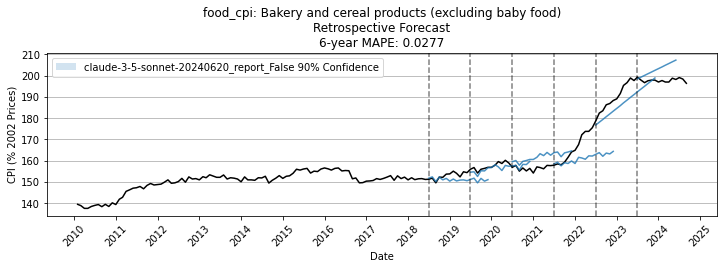

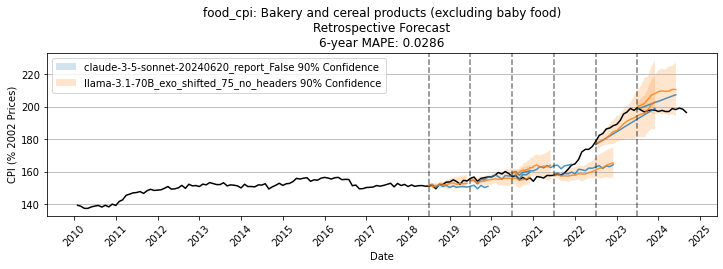

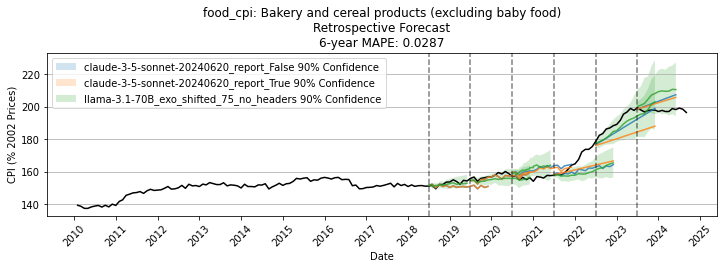

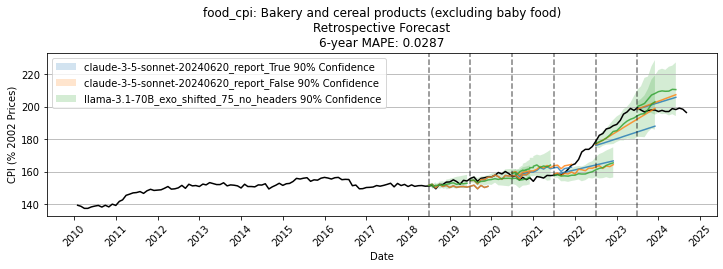

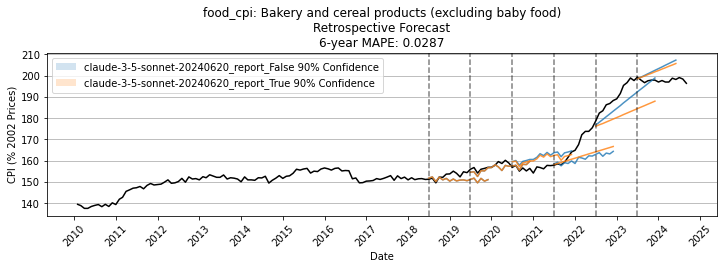

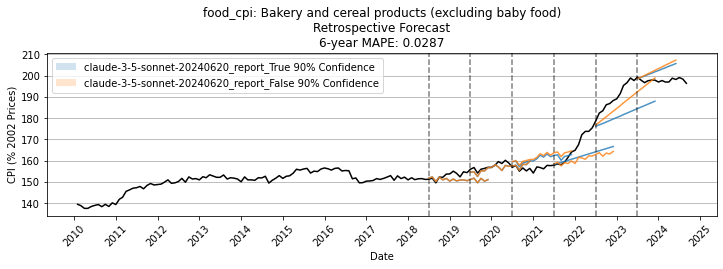

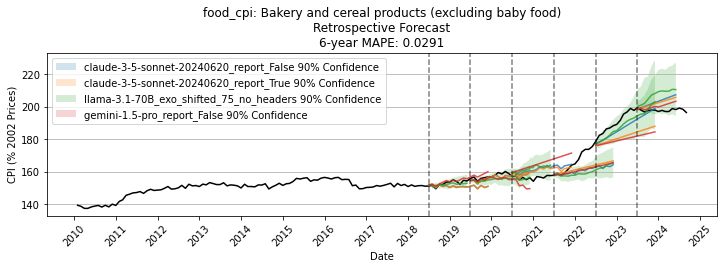

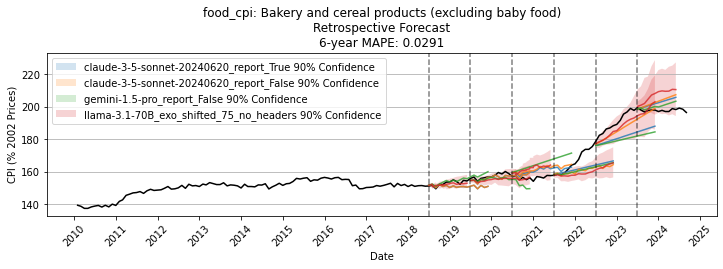

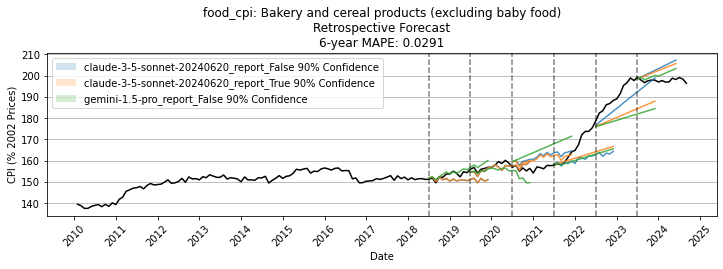

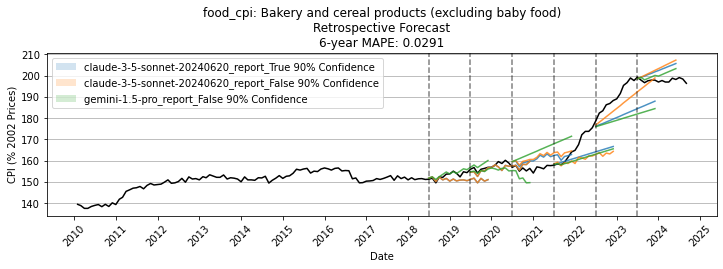

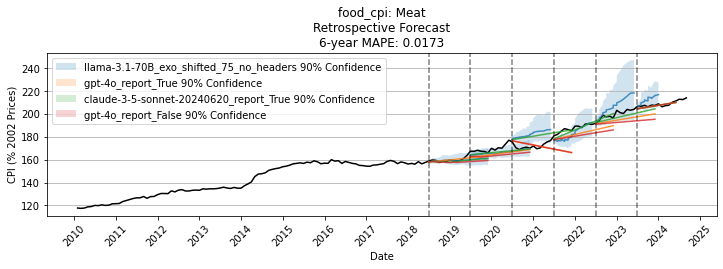

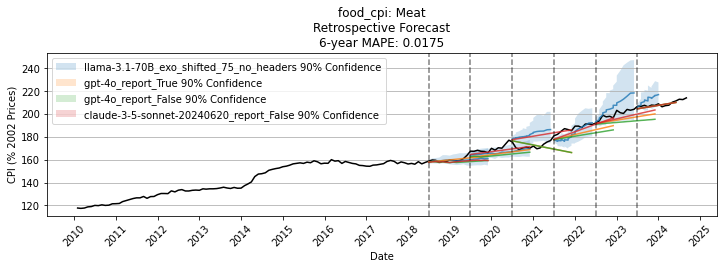

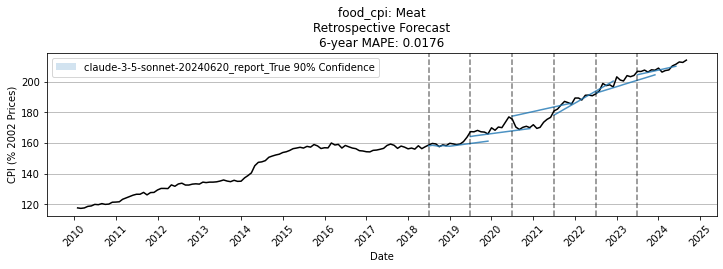

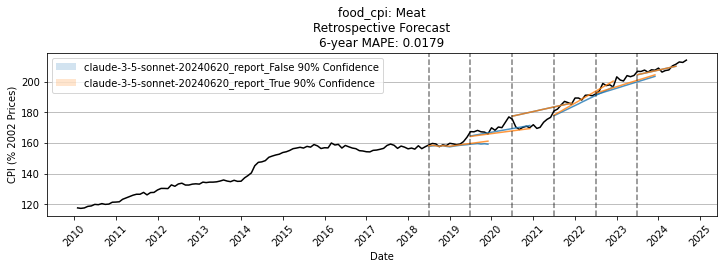

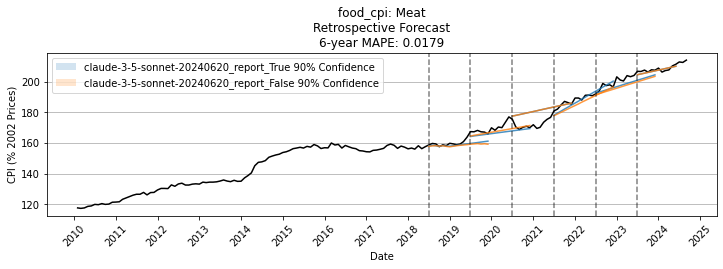

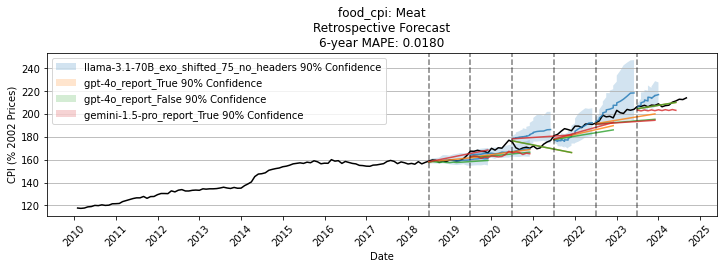

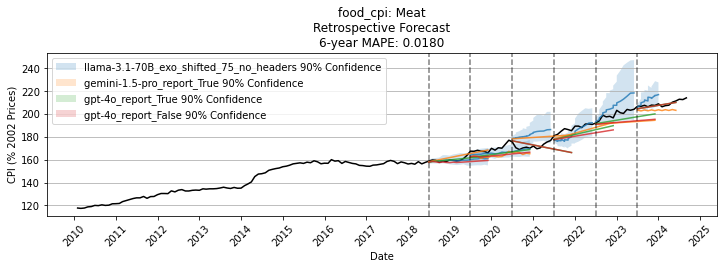

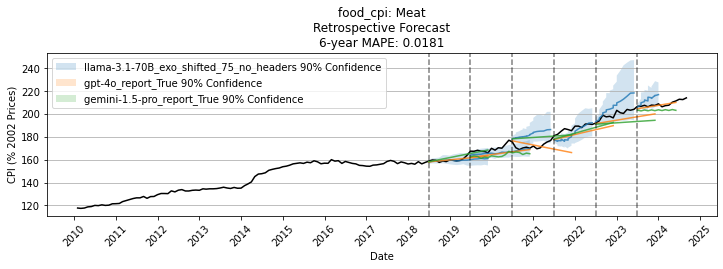

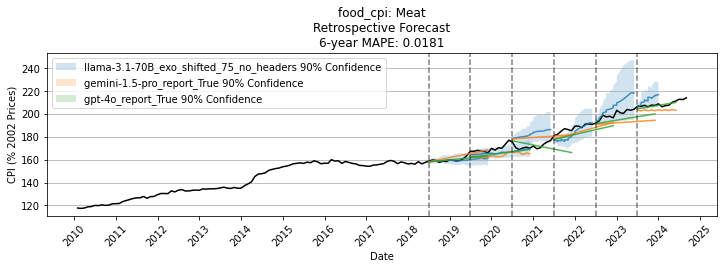

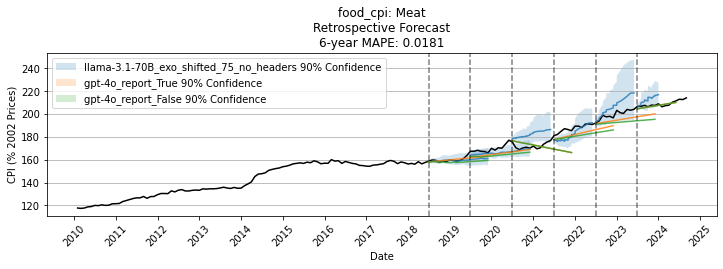

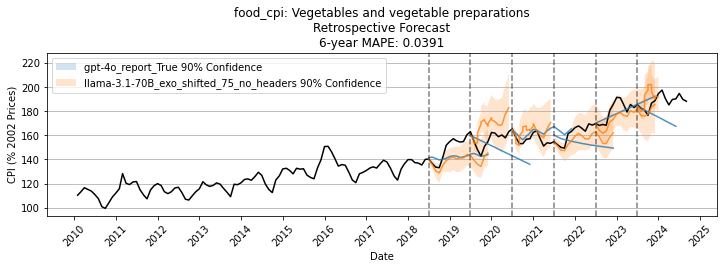

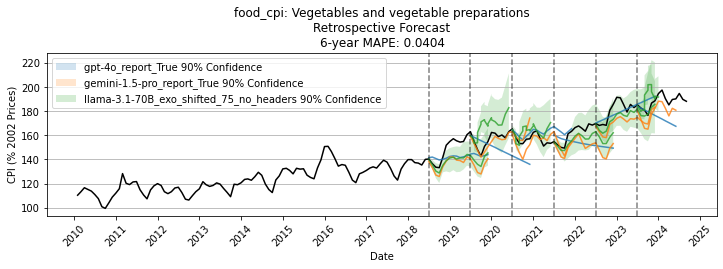

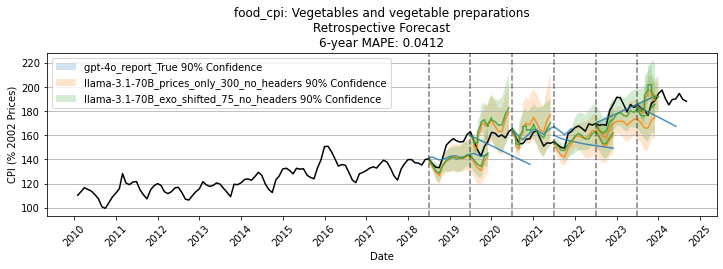

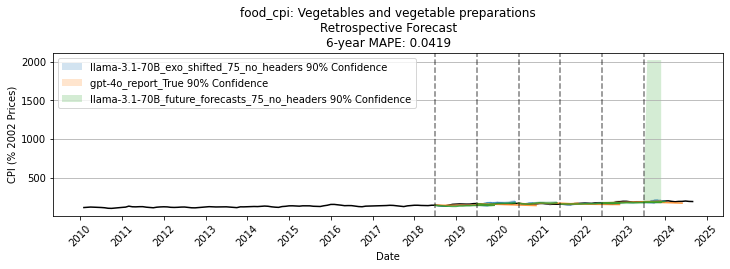

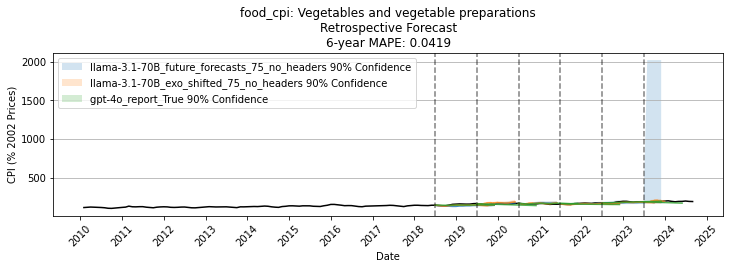

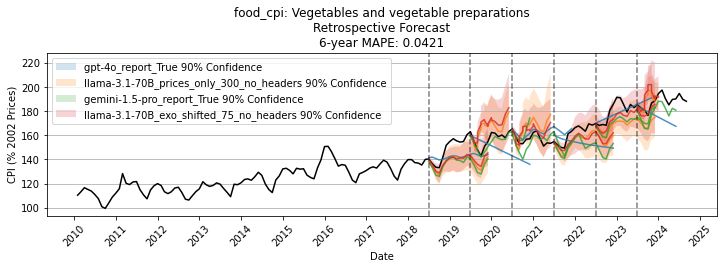

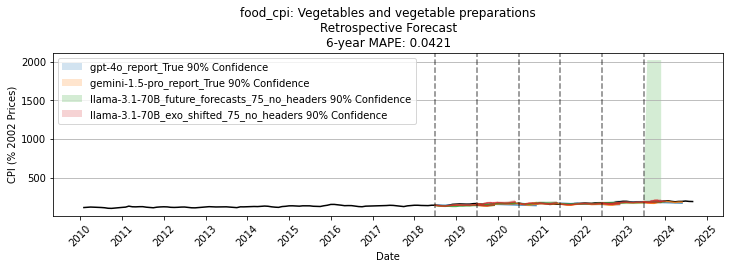

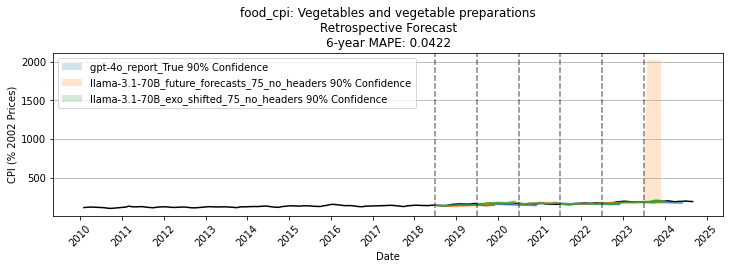

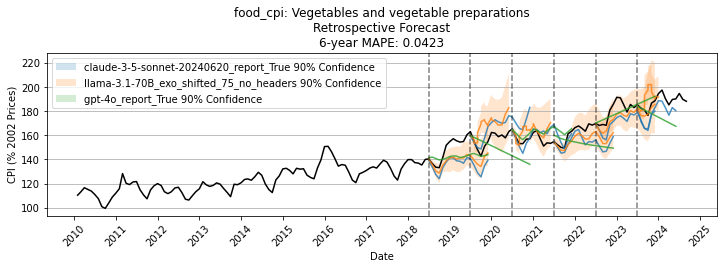

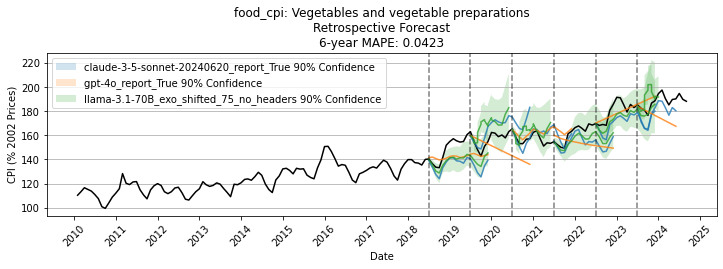

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cutoff_dates = report_sim_dates

for index, (category, top_experiment, mean_score, std_score) in best_results_year_df.iterrows():
    ensemble_experiments = top_experiment.split('+')

    ensemble_forecast_data = []

    for ensemble_experiment in ensemble_experiments:
        forecast_dfs = []
        for date in cutoff_dates:
            forecast_csv_path = f"../generate_forecasts/output/LLMP_Experiments/{ensemble_experiment}/random_seed_{random_seed}/{date}/forecasts/{category}.csv"
            forecast_df = pd.read_csv(forecast_csv_path, index_col=0).iloc[-18:]
            forecast_df.index = pd.to_datetime(forecast_df.index)
            forecast_dfs.append(forecast_df)

        ensemble_forecast_data.append((ensemble_experiment, forecast_dfs))

    context_df = foodprice_df.loc[(foodprice_df.index > "2010-01-01") & (foodprice_df.index <= cutoff_dates[0])][category]
    actual_df = foodprice_df.loc[foodprice_df.index >= cutoff_dates[0]][category]

    save_path = f"./subimages/{category}_best_ensemble_forecast.png"  # Replace with the actual path if you're saving plots

    # plot for multiple ensemble methods, including the mean forecast if applicable
    plot_quantile_forecasts_multiple(category, context_df, ensemble_forecast_data, actual_df, cutoff_dates, model_name=f"6-year MAPE: {mean_score:.4f}", save_path=save_path, plot_mean=False)